In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits#
import matplotlib.patches as patches
from copy import copy

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/azoft-sans.ttf'  # Your font path goes here
font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif', 'DejaVu Sans']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rc('axes', unicode_minus=False)
plt.rcParams["axes.unicode_minus"] = False

In [3]:
from rtfunctions import one_full_fs, sc_2nd_order, calc_lambda_full, calc_lambda_monoc

<h1>Finite slab</h1>

<p>We want to solve radiative transfer problem in finite slab, that is in bounded part of the atmosphere. We assume two level atom model and non-LTE conditions. For starters we shall focus on non-illuminated free-standing finite slab, and will work our way to the illuminated case.</p>

In [4]:
# Let's define the solver function for ALI approach

# It should only deal with solving radiative transfer problem
from scipy.special import wofz
def two_lvl_nlte_solver(tau, NM, NL, B, eps, profile_type, low_bound, up_bound, lratio = 1E3):
    ND = len(tau) # number of optical depth points
    logtau = np.log10(tau)
    # tau - optical depth grid in form of np.array
    # NM - number of points for angle grid
    # NL - number of points for wavelength/frequency grid
    # Planck's function
    B_arr = np.zeros(ND)
    B_arr[:] = B

    # Photon destruction probability
    epsilon = np.zeros(ND)
    epsilon[:] = eps

    # Reduced wavlength in Doppler widths
    x = np.linspace(-6, 6, NL)

    # Profile type: Doppler, Voight or Lorentz
    if (profile_type == 1):
        # Doppler profile
        profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))
    elif profile_type == 2:
        # Voigt profile
        alpha = float(input("Please enter the value for alpha: "))
        gamma = float(input("Please enter the value for gamma: "))
        sigma = alpha / np.sqrt(2 * np.log(2))
        profile = np.real(wofz((x + 1j * gamma) / sigma / np.sqrt(2)))/sigma/np.sqrt(2 * np.pi)
    elif profile_type == 3:
        # Lorentz profile
        profile = 1/np.pi * (1 + x**2)
    else:
        print("Profile type must be 1, 2 or 3")

    # Quadrature (at some point in the future this will be in separate function)
    
    # Weights for wavelengths
    
    wx = np.zeros(NL)
    wx[0] = (x[1] - x[0]) * 0.5
    wx[-1] = (x[-1] - x[-2]) * 0.5
    wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
    norm = (np.sum(profile*wx))
    wx = wx/norm
    
    # Angle integration:
    
    mu=([1./np.sqrt(3.0)])
    wmu=[1.0]

    # Third approximation
    mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
    wmu=[.2777777778,0.4444444444,0.2777777778]
    
    #Fourth approximation
    #mu = np.array([0.06943184, 0.33000948, 0.66999052, 0.93056816])
    #wmu = [0.173927419815906, 0.326072580184089, 0.326072580184104, 0.173927419815900]
    NM = mu.shape[0]
    mu = np.asarray(mu)
    wmu = np.asarray(wmu)

    # One figure for plotting the source function
    fig = plt.figure(constrained_layout = True, figsize = (13, 7))

    # Relative error
    rel_err = np.zeros((500))
    res = [] # in case we want this function to return [S, Lamba_operator]
    
    # Solve radiative transfer equation (first by using Ivan's functions)
    S = np.copy(B_arr) # the source function 
    # We will iterate 'till the convergence
    for j in range(0, 500):
        J = np.zeros(ND) # initialize the scattering integral
        L = np.zeros(ND) # initialize the Lambda operator
        # For each direction and wavelength, calculate monochromatic intensity and add its contribution to the scattering integral
        for m in range(0, NM):
            for l in range(0, NL):

                # outward

                I_Lambda = sc_2nd_order(tau * profile[l] * lratio, S, mu[m], low_bound)

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

                # inward

                I_Lambda = sc_2nd_order(tau * profile[l] * lratio, S, -mu[m], up_bound)

                J = J + I_Lambda[0] * profile[l] * wx[l] * wmu[m] * 0.5

                L = L + I_Lambda[1] * profile[l] * wx[l] * wmu[m] * 0.5

        # Correct the source function using the local ALI approach
        dS = (epsilon * B_arr + (1. - epsilon) * J - S)/(1. - (1. - epsilon) * L)

        # Check for change
        max_change = np.max(np.abs(dS/S))
        rel_err[j] = max_change
        #print(rel_err[j])

        S += dS
        plt.semilogy(logtau, S, '-k', alpha = 0.20)
        if(max_change < 1E-4):
            break
        fin = S    
    plt.xlabel("$\\log\\tau$ in the line")
    plt.ylabel("$\\log$S")
    #LL = calc_lambda_full(tau * lratio, mu, wmu, profile, wx)
    # res.append(fin)
    # res.append(LL)
    # return res
    return fin
    

In [5]:
# Here we define function for basic lambda iteration
def two_level_atom_LI(tau, NM, NL, B, eps, profile_type, low_bound, up_bound, lratio = 1E3):
    ND = len(tau) # number of optical depth points
    logtau = np.log10(tau)
    # tau - optical depth grid in form of np.array
    # NM - number of points for angle grid
    # NL - number of points for wavelength/frequency grid
    # Planck's function
    B_arr = np.zeros(ND)
    B_arr[:] = B

    # Photon destruction probability
    epsilon = np.zeros(ND)
    epsilon[:] = eps

    # Reduced wavlength in Doppler widths
    x = np.linspace(-6, 6, NL)

    # Profile type: Doppler, Voight or Lorentz
    if (profile_type == 1):
        # Doppler profile
        profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))
    elif profile_type == 2:
        # Voigt profile
        alpha = float(input("Please enter the value for alpha: "))
        gamma = float(input("Please enter the value for gamma: "))
        sigma = alpha / np.sqrt(2 * np.log(2))
        profile = np.real(wofz((x + 1j * gamma) / sigma / np.sqrt(2)))/sigma/np.sqrt(2 * np.pi)
    elif profile_type == 3:
        # Lorentz profile
        profile = 1/np.pi * (1 + x**2)
    else:
        print("Profile type must be 1, 2 or 3")

    # Quadrature (at some point in the future this will be in separate function)
    
    # Weights for wavelengths
    
    wx = np.zeros(NL)
    wx[0] = (x[1] - x[0]) * 0.5
    wx[-1] = (x[-1] - x[-2]) * 0.5
    wx[1:-1] = (x[2:NL] - x[0:-2]) * 0.5
    norm = (np.sum(profile*wx))
    wx = wx/norm
    
    # Angle integration:
    
    mu=([1./np.sqrt(3.0)])
    wmu=[1.0]
    mu=np.cos([0.4793425352,1.0471975512,1.4578547042])
    wmu=[.2777777778,0.4444444444,0.2777777778]
    #mu = [-np.sqrt(3)/3, 0, np.sqrt(3)/3]
    #wmu = [5/9, 8/9, 5/9]
    NM = mu.shape[0]
    mu = np.asarray(mu)
    wmu = np.asarray(wmu)

    # One figure for plotting the source function
    fig = plt.figure(constrained_layout = True, figsize = (13, 7))

    # Relative error
    rel_err = np.zeros((1000))
    res = [] # in case we want this function to return [S, Lamba_operator]
    
    # Solve radiative transfer equation (first by using Ivan's functions)
    S = np.copy(B_arr) # the source function 
    for iter in range(0,1000):
    # initialize the scattering integral
        J = np.zeros(ND)
        for m in range(0,NM):
            for l in range(0,NL):
                #outward
                I = sc_2nd_order(tau*profile[l]*lratio,S,mu[m],low_bound)[0]
                J+=I*profile[l]*wx[l]*wmu[m]*0.5
                #inward
                I = sc_2nd_order(tau*profile[l]*lratio,S,-mu[m],up_bound)[0]
                J+=I*profile[l]*wx[l]*wmu[m]*0.5
        
        dS = eps * B + (1.-eps)*J - S
        max_change = np.amax(np.abs(dS/S))
        #print (max_change)
        S += dS
        plt.semilogy(logtau+3, S,'-k',alpha=0.2)
        if(max_change < 1E-4):
                break
        fin = S    
    plt.xlabel("$\\log\\tau$ in the line")
    plt.ylabel("Source function")

    return fin

In [6]:
# Let's define a function that defines the finite slab in terms of optical depth 
# and return the log_tau grid

# We want a slab with given optical thickness T, and some minimum thickne at the surface. 
# And we want given number of points per decade. 
# AND we want the slab to be symmetric around the middle, meaning very fine separation at the edges and coarse 
# in the middle.

def tau_grid(taumin, taumax, np_per_dec):
    # How many decades in total?
    n_decades = np.log10(taumax / taumin)
    print(n_decades)

    # How many decades until the middle of the slab?
    n_dec_mid = np.log10(taumax / taumin / 2)
    print(n_dec_mid)

    # Total number of points is then: 
    ND = int (np_per_dec * n_dec_mid) + 1
    print(ND)

    # Now, the step is, actually: 
    logstep = np.log10(taumax / taumin / 2) / (ND - 1)
    print(logstep)

    # Make log grid for a half of the slab:
    logtau_half = np.linspace(np.log10(taumin), np.log10(taumax/2), ND)

    tau_half = 10**logtau_half

    #print(tau_half)

    tau_second_half = taumax - tau_half[::-1]

    tau_full = np.concatenate((tau_half, tau_second_half[1:]))

    #print(tau_full)

    return tau_full
    

In [7]:
def element_difference(arr):
    diff_arr = np.zeros(len(arr))
    for j in range(len(arr)):
        nth_from_start = arr[j - 1] # Python lists are 0-indexed
        nth_from_end = arr[-j]
        diff_arr[j] = nth_from_start - nth_from_end
        #print(f"Difference between {n}-th element from start and {n}-th from end: {difference}")
    return diff_arr

<h3>Mihalas (1978) results</h3>
<p>First and foremost goal is to obtain the results that Mihalas shows for finite free-standing slab (no illumination).</p>
<p>We start by reproducing <b><i>Fig. 11.3</i></b> and work our way through the rest of the chapter without extended atmospheres.</p>

6.0
5.698970004336019
69
0.08380838241670616


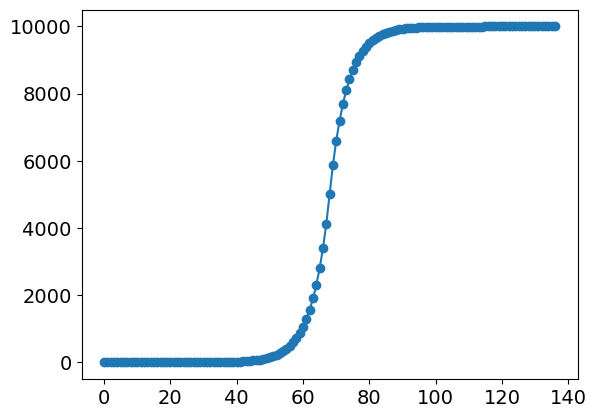

In [8]:
# Create tau grid
tau = tau_grid(1E-2, 1E4, 12)
# Upper boundary affects the S!!!!!
# If taumin (tau_upper) = 1E-5 for instance, the results are very different!!!!
logtau = np.log10(tau)
#logtau = np.linspace(-5, 10, 209)
plt.plot(tau, '-o')

<h3><b>ALI</b> - accelerated (approximate) $\Lambda$ - iteration</h3>

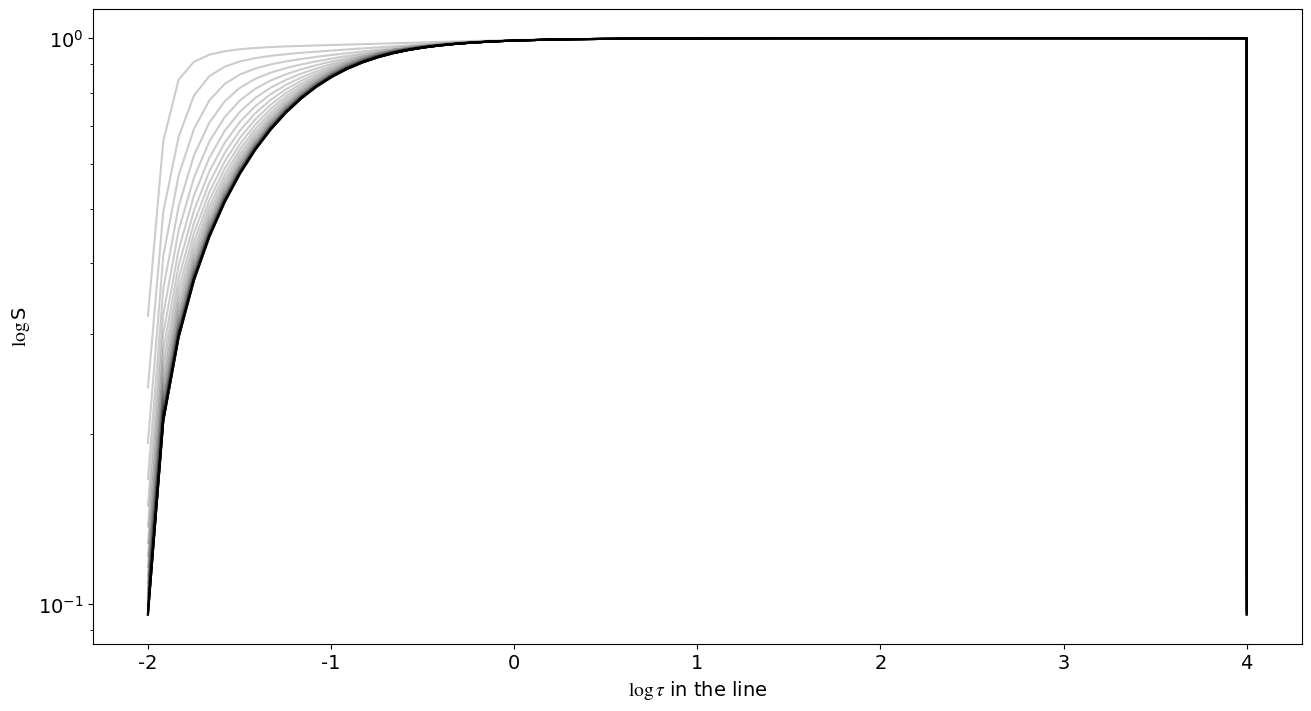

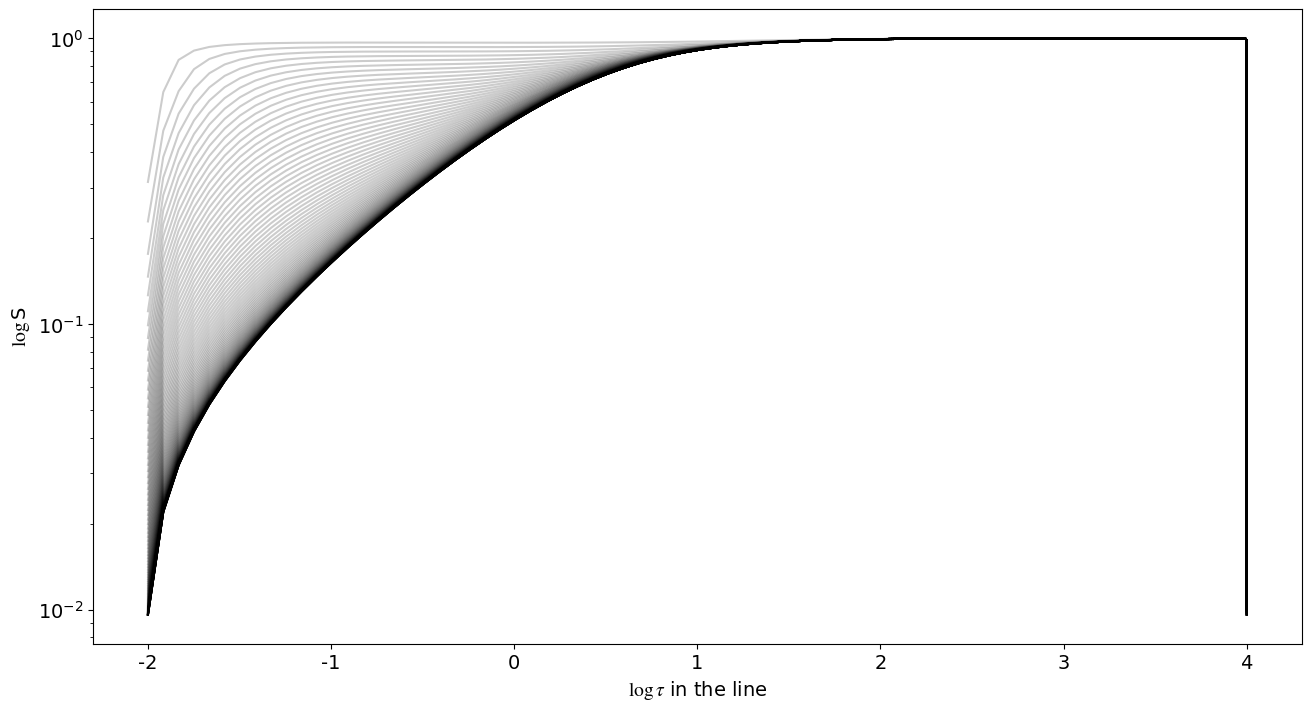

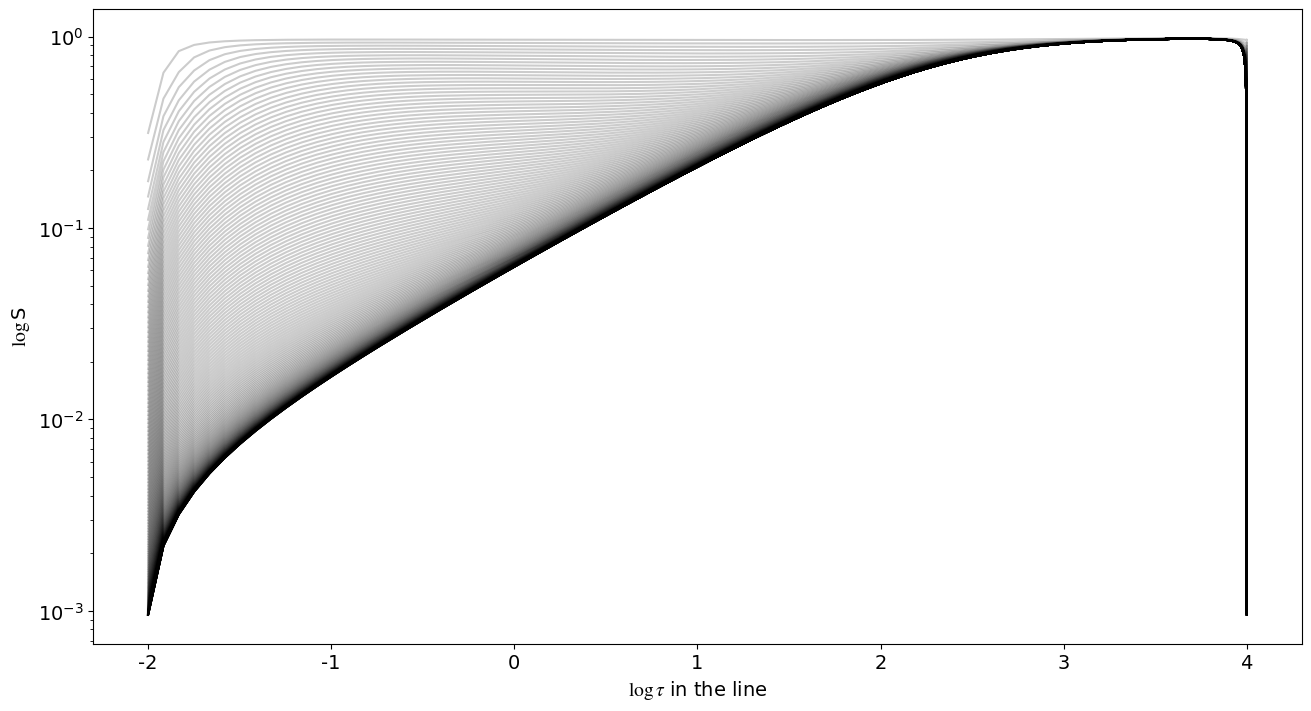

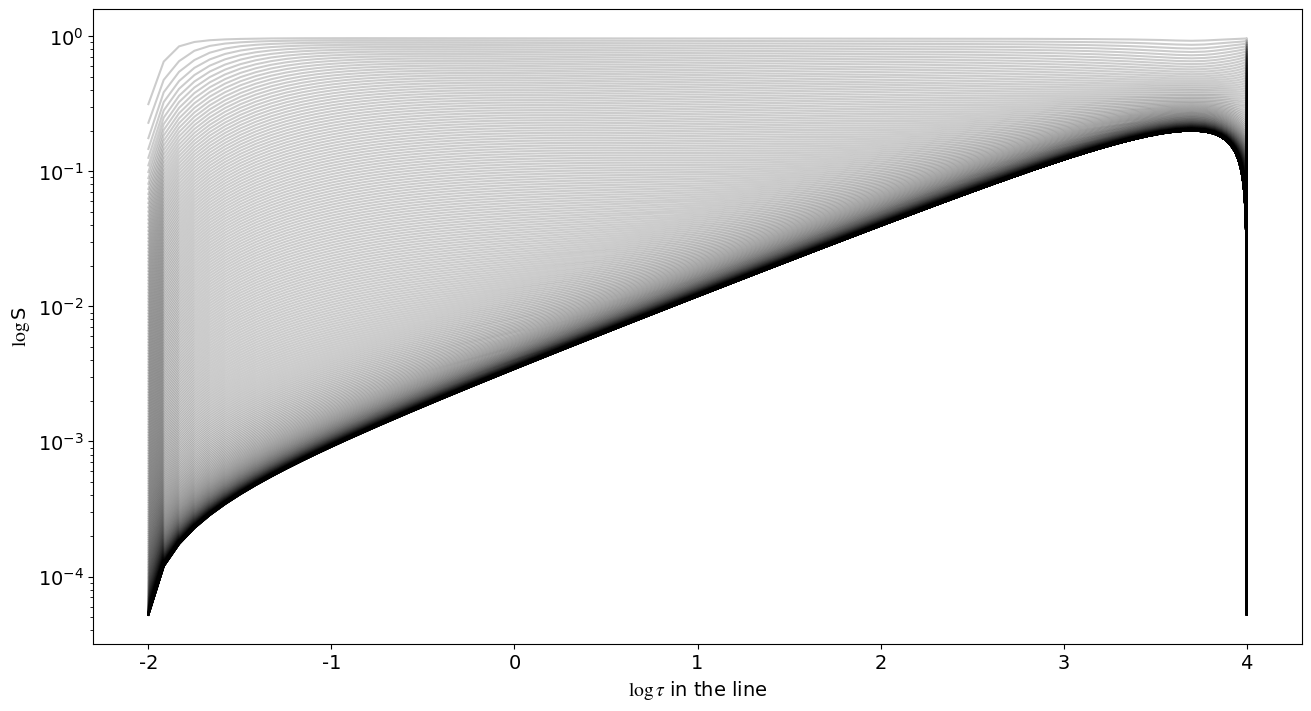

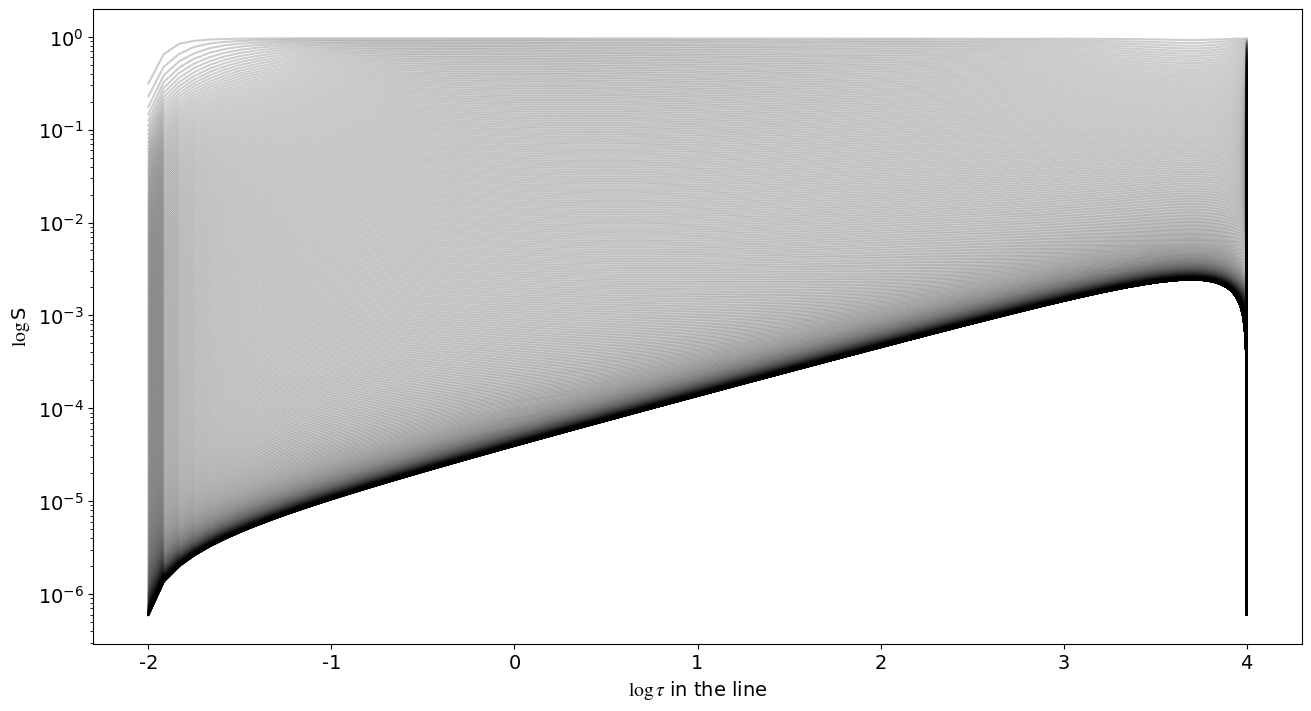

In [9]:
S_D_finite_e2_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-2, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e4_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e6_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-6, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e8_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-8, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e10_T4 = two_lvl_nlte_solver(tau, 3, 121, 1.0, 1E-10, 1, low_bound = 0.0, up_bound = 0.0)

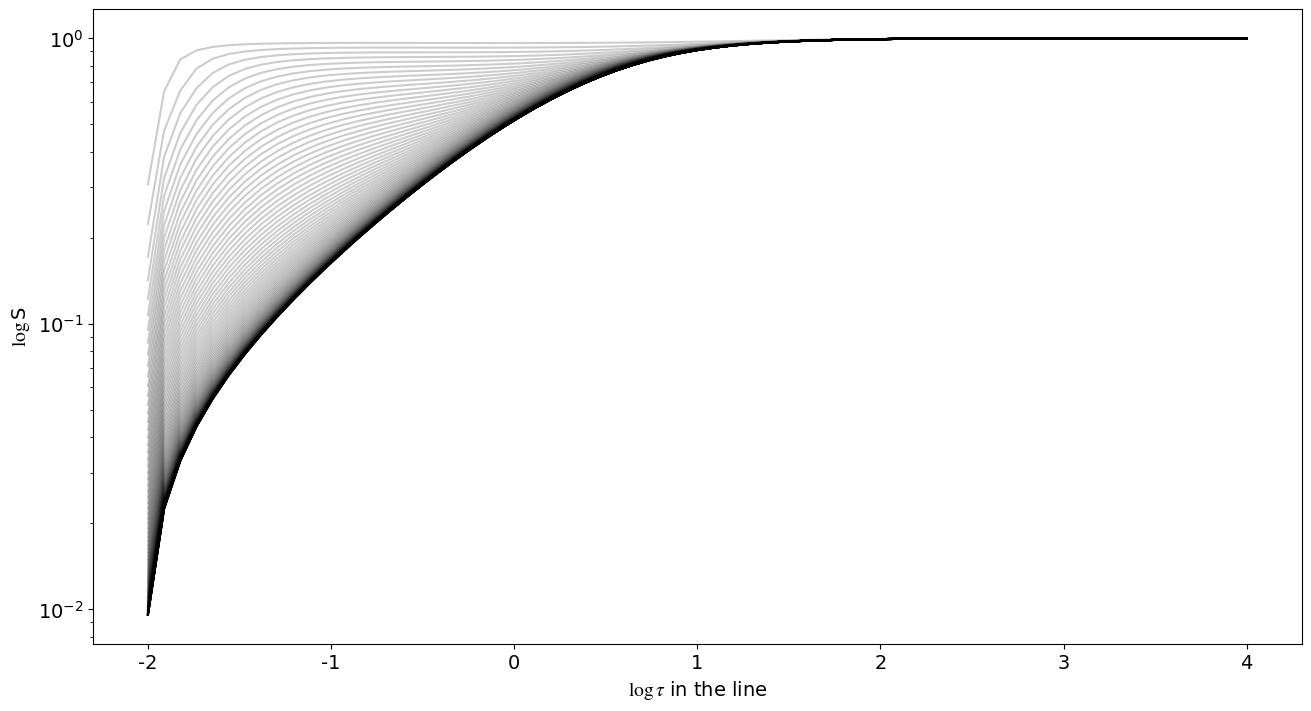

In [10]:
ltau = np.linspace(-2, 4, 69)
tau_l = 10**ltau
S_D_e4 = two_lvl_nlte_solver(tau_l, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0)

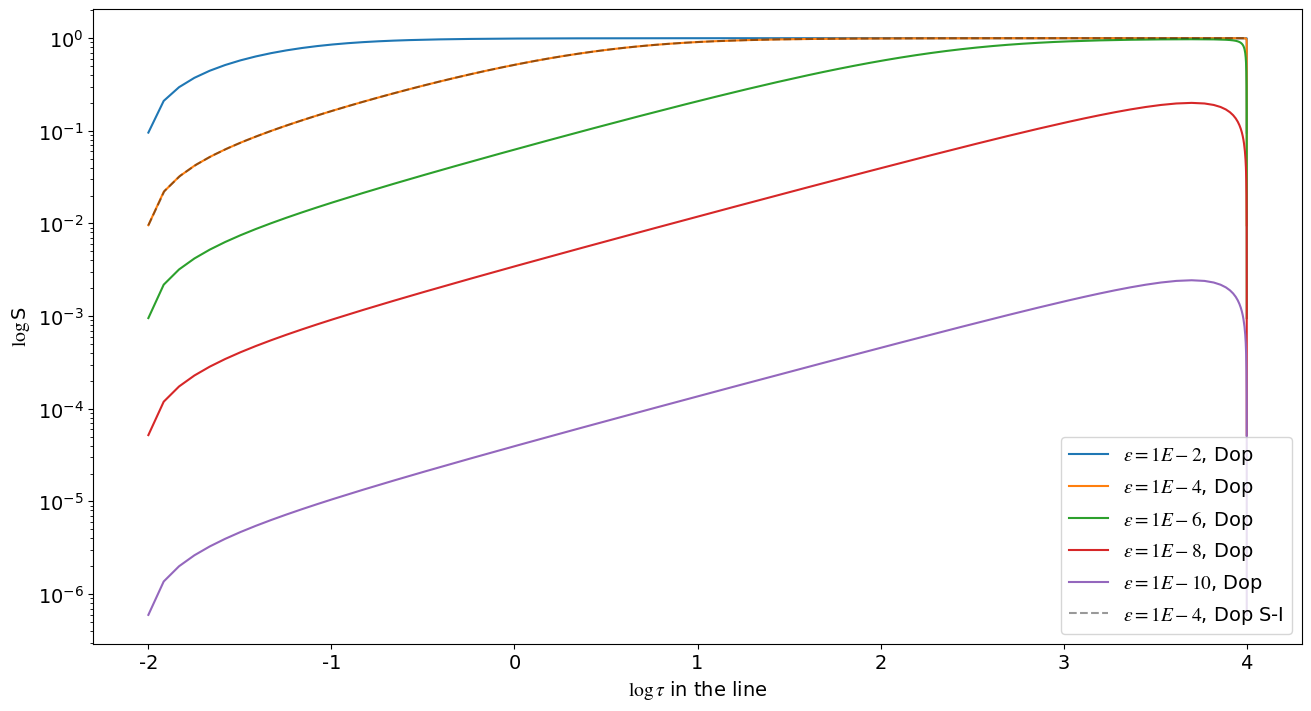

In [11]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau, S_D_finite_e2_T4, label = "$\\varepsilon = 1E-2$, Dop")
plt.semilogy(logtau, S_D_finite_e4_T4, label = "$\\varepsilon = 1E-4$, Dop")
plt.semilogy(logtau, S_D_finite_e6_T4, label = "$\\varepsilon = 1E-6$, Dop")
plt.semilogy(logtau, S_D_finite_e8_T4, label = "$\\varepsilon = 1E-8$, Dop")
plt.semilogy(logtau, S_D_finite_e10_T4, label = "$\\varepsilon = 1E-10$, Dop")
plt.semilogy(ltau, S_D_e4, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 1)

<h3>Is source function symmetric with regard to middle of the slab?</h3>

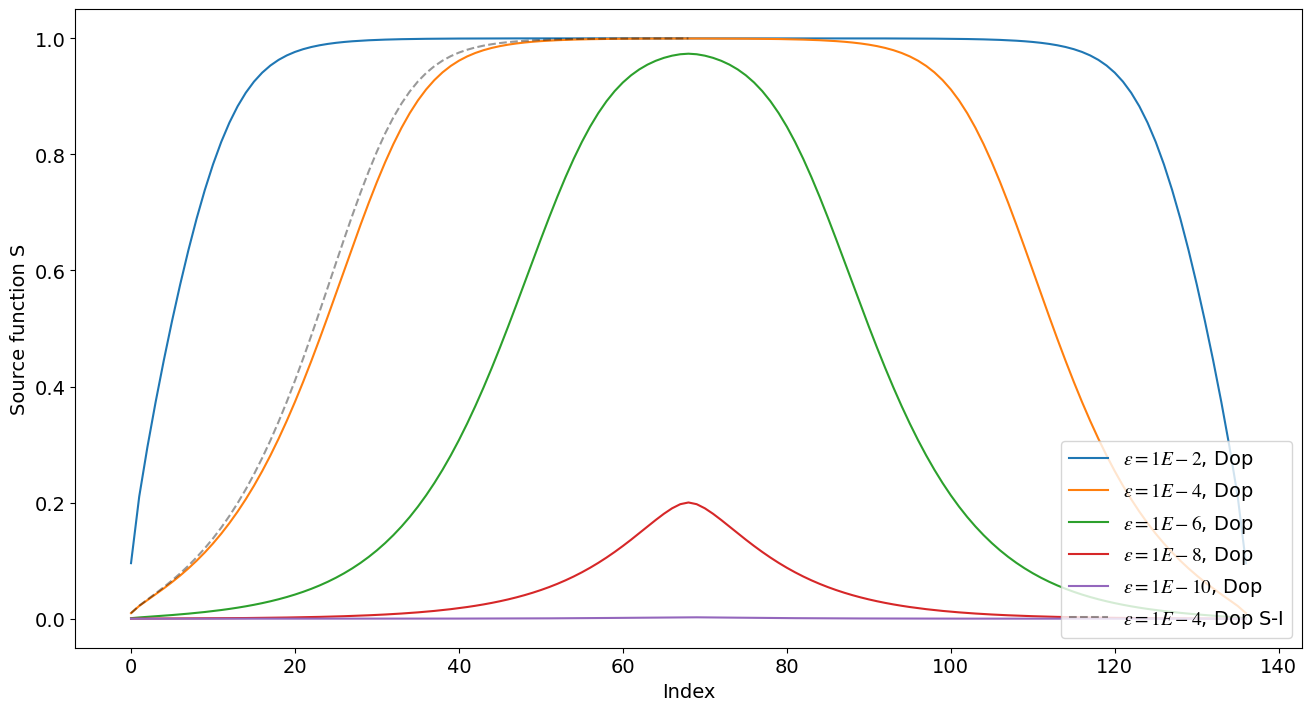

In [12]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("Index")
plt.ylabel("Source function S")
plt.plot(S_D_finite_e2_T4, label = "$\\varepsilon = 1E-2$, Dop")
plt.plot(S_D_finite_e4_T4, label = "$\\varepsilon = 1E-4$, Dop")
plt.plot(S_D_finite_e6_T4, label = "$\\varepsilon = 1E-6$, Dop")
plt.plot(S_D_finite_e8_T4, label = "$\\varepsilon = 1E-8$, Dop")
plt.plot(S_D_finite_e10_T4, label = "$\\varepsilon = 1E-10$, Dop")
plt.plot(S_D_e4, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 1)

(137,)
(137,)
(137,)
(137,)
(137,)


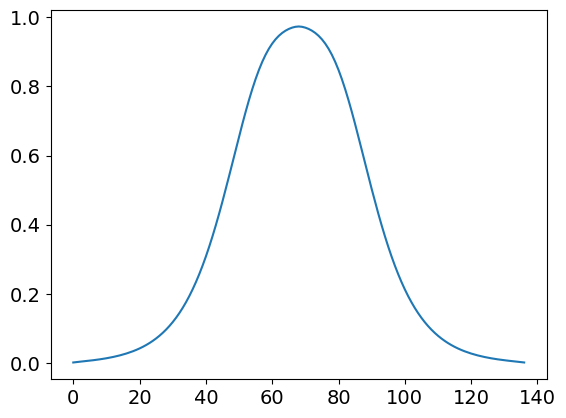

In [13]:
plt.plot(S_D_finite_e6_T4)
print(np.shape(S_D_finite_e2_T4))
print(np.shape(S_D_finite_e4_T4))
print(np.shape(S_D_finite_e6_T4))
print(np.shape(S_D_finite_e8_T4))
print(np.shape(S_D_finite_e10_T4))

In [14]:
S_D_finite_e6_T4_diff = element_difference(S_D_finite_e6_T4)
print(S_D_finite_e6_T4_diff)

[ 2.64855412e-14 -2.64855412e-14  3.35536286e-13  1.42790293e-13
 -5.88461571e-14  2.28925386e-13  3.88855614e-14 -3.83911652e-14
  1.09570339e-13  2.17669632e-13  9.74220704e-14  1.45800039e-13
  1.75415238e-14  5.39117362e-14  9.94204719e-14  1.29753847e-13
  1.12472531e-13  1.85833987e-13  1.44158990e-13  9.40358902e-14
  7.63625274e-14  7.79792897e-14  9.14338050e-14  8.79782358e-14
  8.49528781e-14  1.76664239e-14 -1.37667655e-14 -4.45754544e-14
  1.60149671e-14 -3.18522986e-13 -2.85577118e-13 -2.65773514e-13
 -2.54879451e-13 -7.62695462e-13 -3.10751425e-13 -1.85573779e-12
 -3.16330295e-13 -3.62249120e-12  2.29261055e-14 -4.60298466e-12
 -4.70329331e-12 -3.55082630e-12 -6.20159479e-12 -2.30261921e-11
 -8.71924755e-12 -3.15819593e-12 -3.22322169e-11 -8.78896955e-12
  2.95998781e-11 -1.29610767e-11 -4.70452566e-11 -9.45898915e-12
  2.97690761e-11 -1.46093138e-10  9.74027525e-11  1.92478811e-10
 -3.32250893e-11 -2.65527600e-11 -3.47255558e-10  4.97533792e-10
  2.02890593e-10  4.58937

In [15]:
n = 20  
my_list = S_D_finite_e6_T4
if len(my_list) >= n and len(my_list) >= n: # Ensure n-th element from both ends exist
    nth_from_start = my_list[n - 1] # Python lists are 0-indexed
    nth_from_end = my_list[-n]
    difference = nth_from_start - nth_from_end
    print(f"Difference between {n}-th element from start and {n}-th from end: {difference}")
else:
    print("List is too short to get the n-th element from both ends.")

Difference between 20-th element from start and 20-th from end: 7.636252741249905e-14


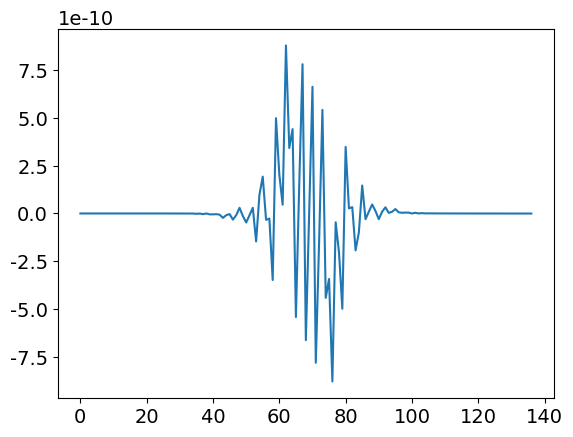

In [16]:
plt.plot(S_D_finite_e6_T4_diff)

<h3>Emergent intensity</h3>
<p>What does emergent intensity (the intensity that passes through) look like? We want to obtain <b><i>Fig. 11.4</i></b> from Mihalas.</p>

2.0
1.6989700043360187
21
0.08494850021680093
4.0
3.6989700043360187
45
0.08406750009854588
6.0
5.698970004336019
69
0.08380838241670616
8.0
7.698970004336019
93
0.08368445656886978
4.0
3.6989700043360187
45
0.08406750009854588


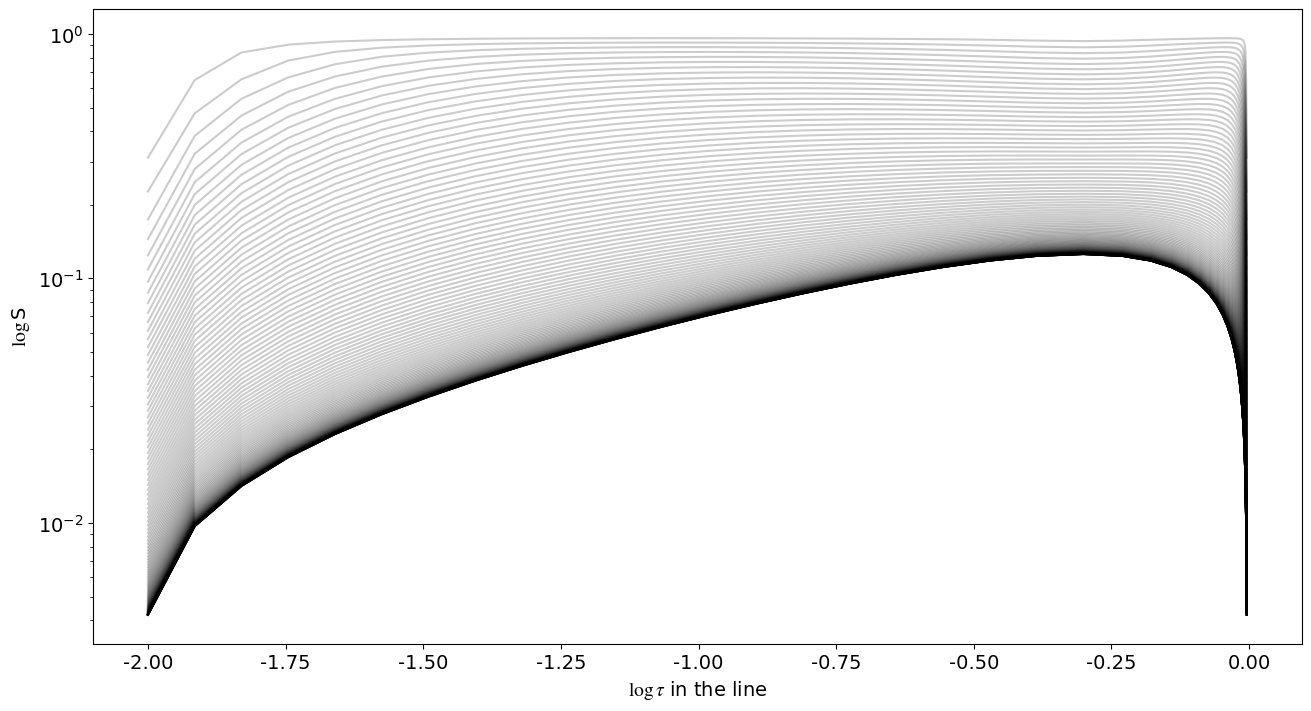

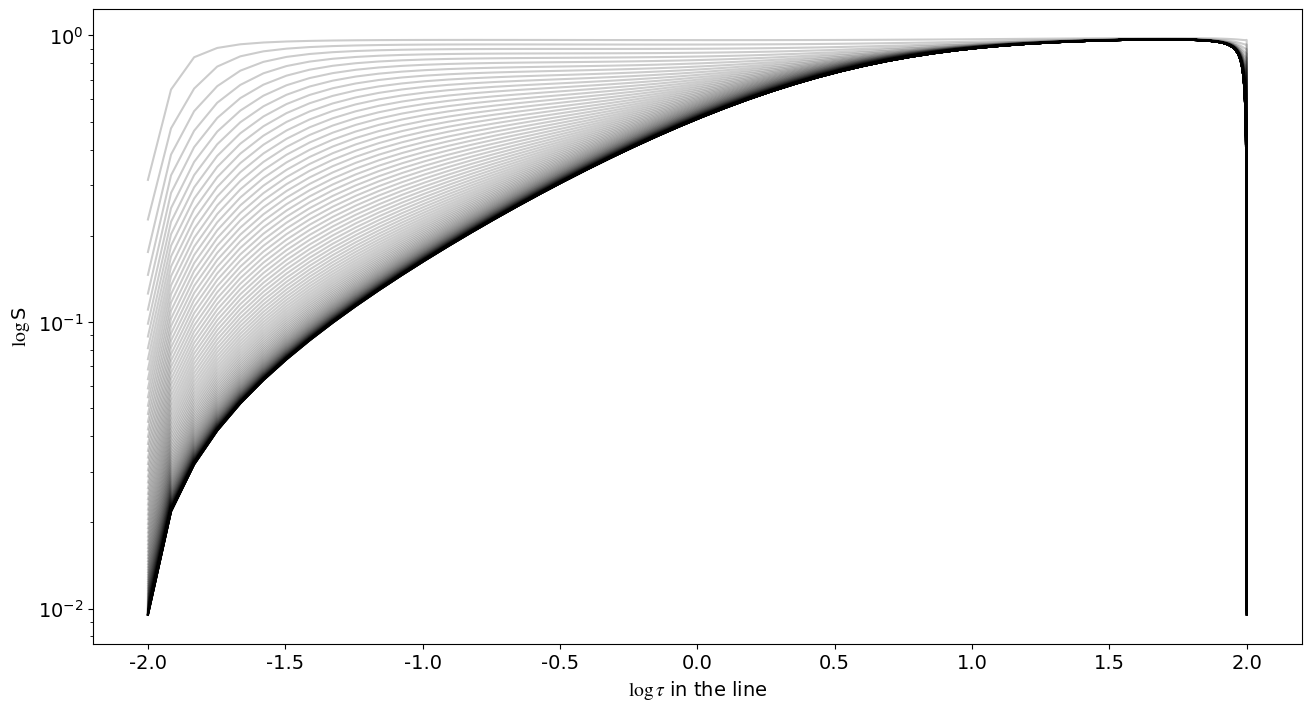

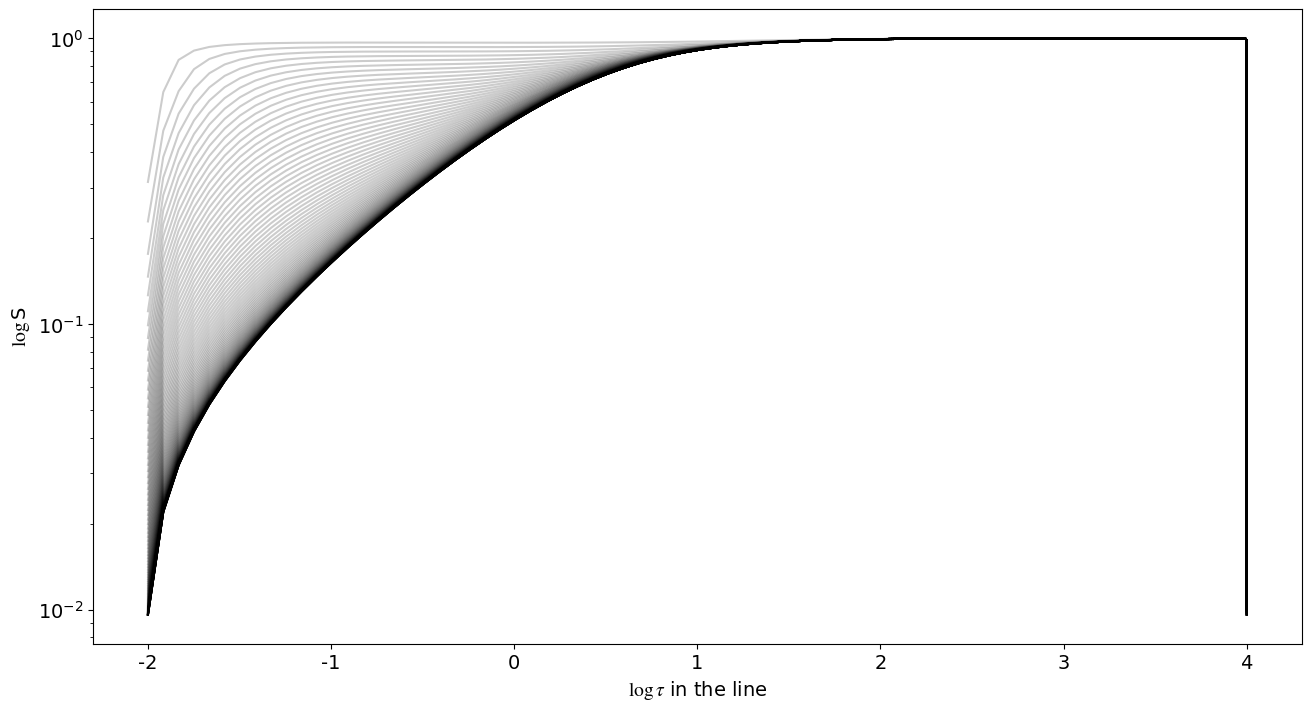

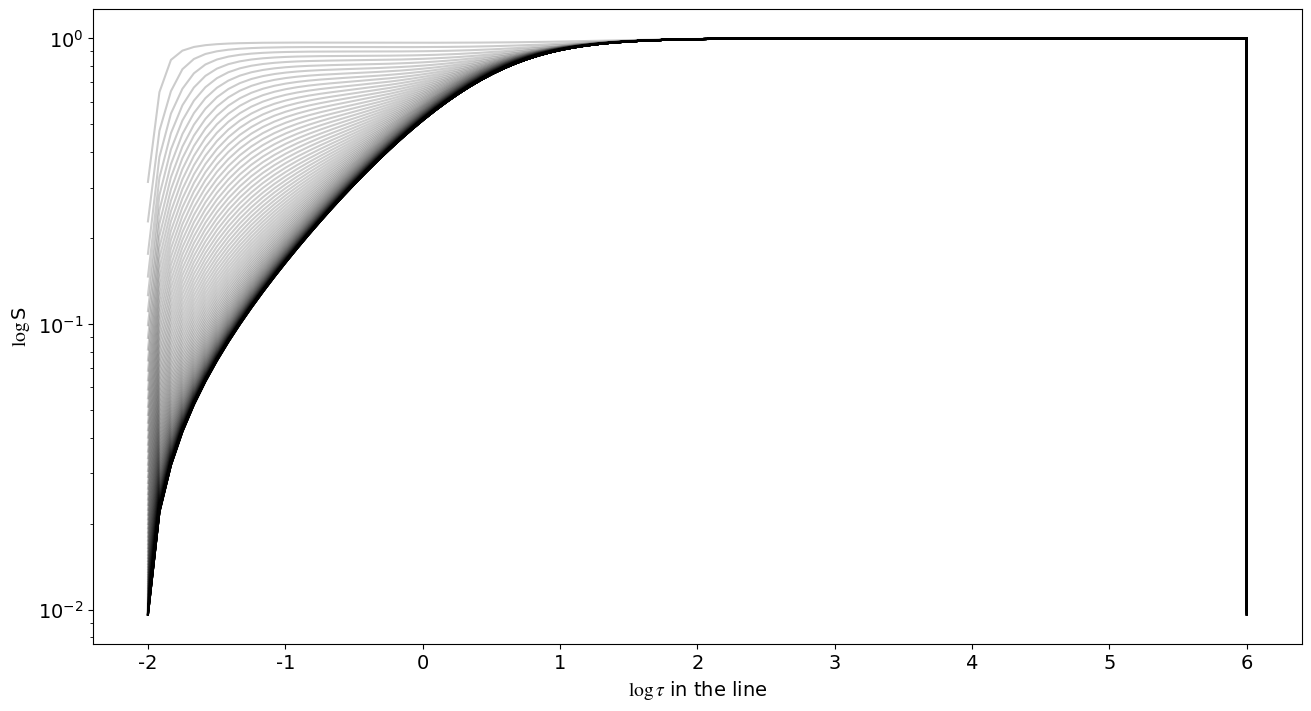

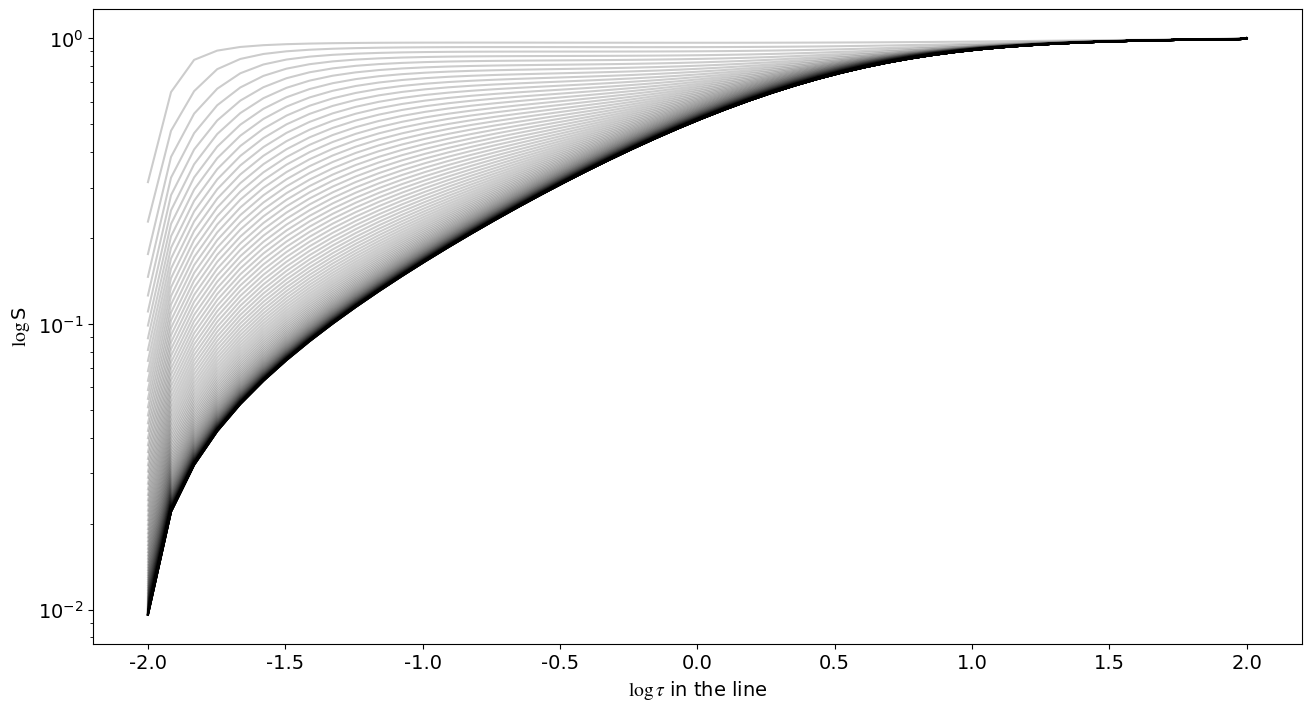

In [17]:
# How about intensity??
lratio = 1E3
x = np.linspace(-6, 6, 121)
profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))

tau2 = tau_grid(1E-2, 1, 12)
S_D_finite_e4_T2 = two_lvl_nlte_solver(tau2, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
#print(S_D_finite_e4_T2)
I_out2 = one_full_fs(tau2*lratio,S_D_finite_e4_T2,1.0,profile,S_D_finite_e4_T2[-1])

tau4 = tau_grid(1E-2, 1E2, 12)
S_D_finite_e4_T4 = two_lvl_nlte_solver(tau4, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out4 = one_full_fs(tau4*lratio,S_D_finite_e4_T4,1.0,profile,S_D_finite_e4_T4[-1])

tau6 = tau_grid(1E-2, 1E4, 12)
S_D_finite_e4_T6 = two_lvl_nlte_solver(tau6, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out6 = one_full_fs(tau6*lratio,S_D_finite_e4_T6,1.0,profile,S_D_finite_e4_T6[-1])

tau8 = tau_grid(1E-2, 1E6, 12)
S_D_finite_e4_T8 = two_lvl_nlte_solver(tau8, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out8 = one_full_fs(tau8*lratio,S_D_finite_e4_T8,1.0,profile,S_D_finite_e4_T8[-1])

taui = tau_grid(1E-2, 1E2, 12)
S_D_e4 = two_lvl_nlte_solver(taui, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
I_outinf = one_full_fs(taui*lratio,S_D_e4,1.0,profile,S_D_e4[-1])

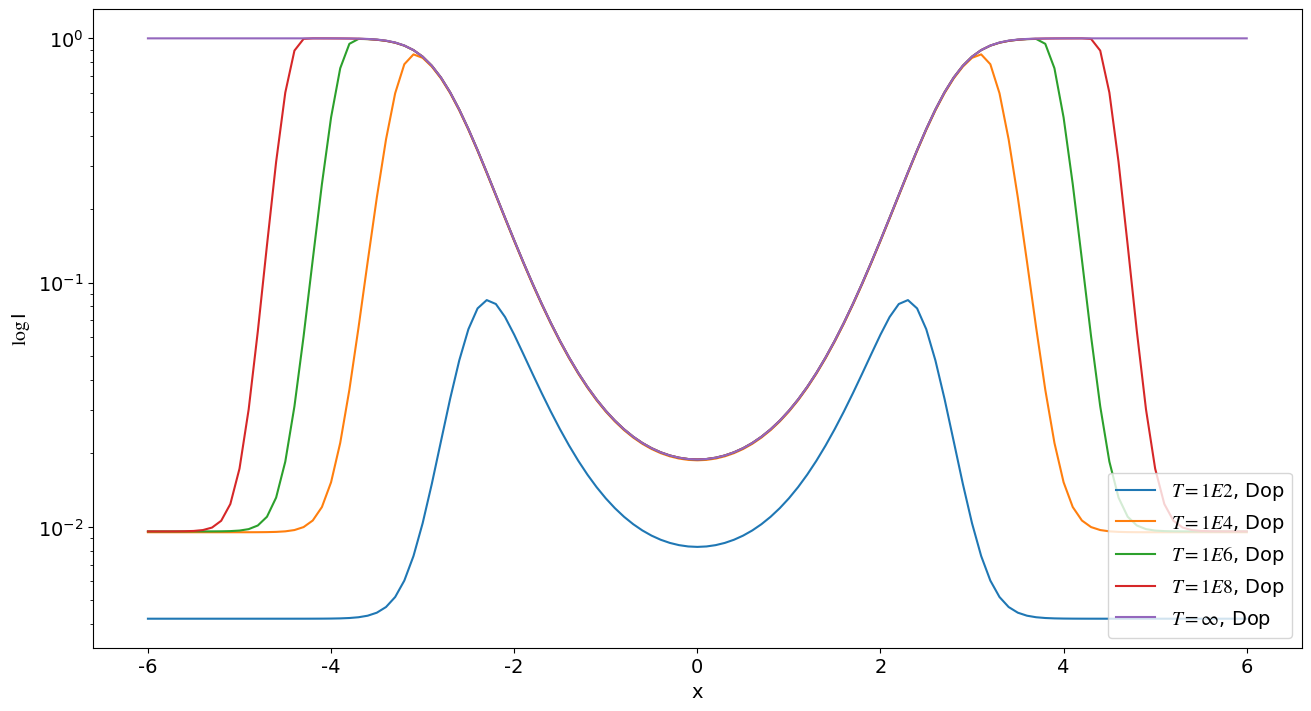

In [18]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("x")
#plt.xlim(0,5)
plt.ylabel("$\\log$I")
plt.semilogy(x, I_out2, label = "$T = 1E2$, Dop")
plt.semilogy(x, I_out4, label = "$T = 1E4$, Dop")
plt.semilogy(x, I_out6, label = "$T = 1E6$, Dop")
plt.semilogy(x, I_out8, label = "$T = 1E8$, Dop")
plt.semilogy(x, I_outinf, label = "$T = \infty$, Dop")
plt.legend(loc = "lower right", ncols = 1)

<h2><b>$\Lambda$-iteration</b></h2>

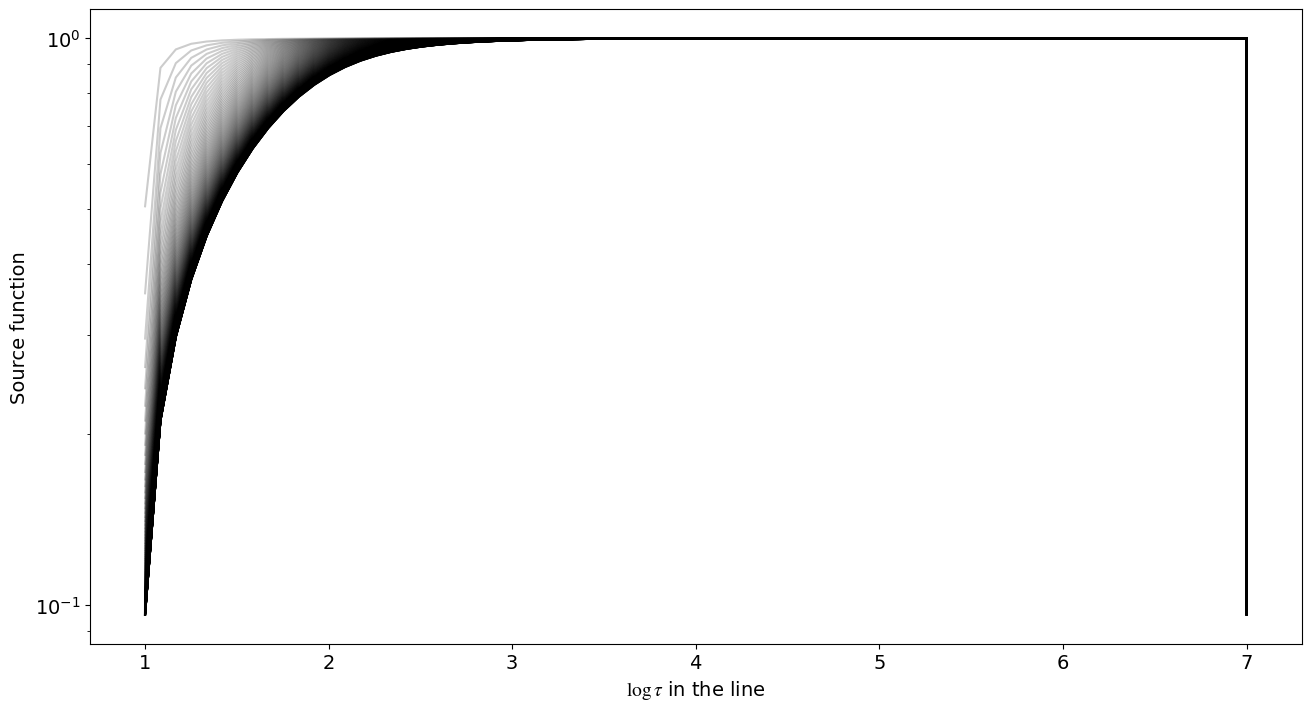

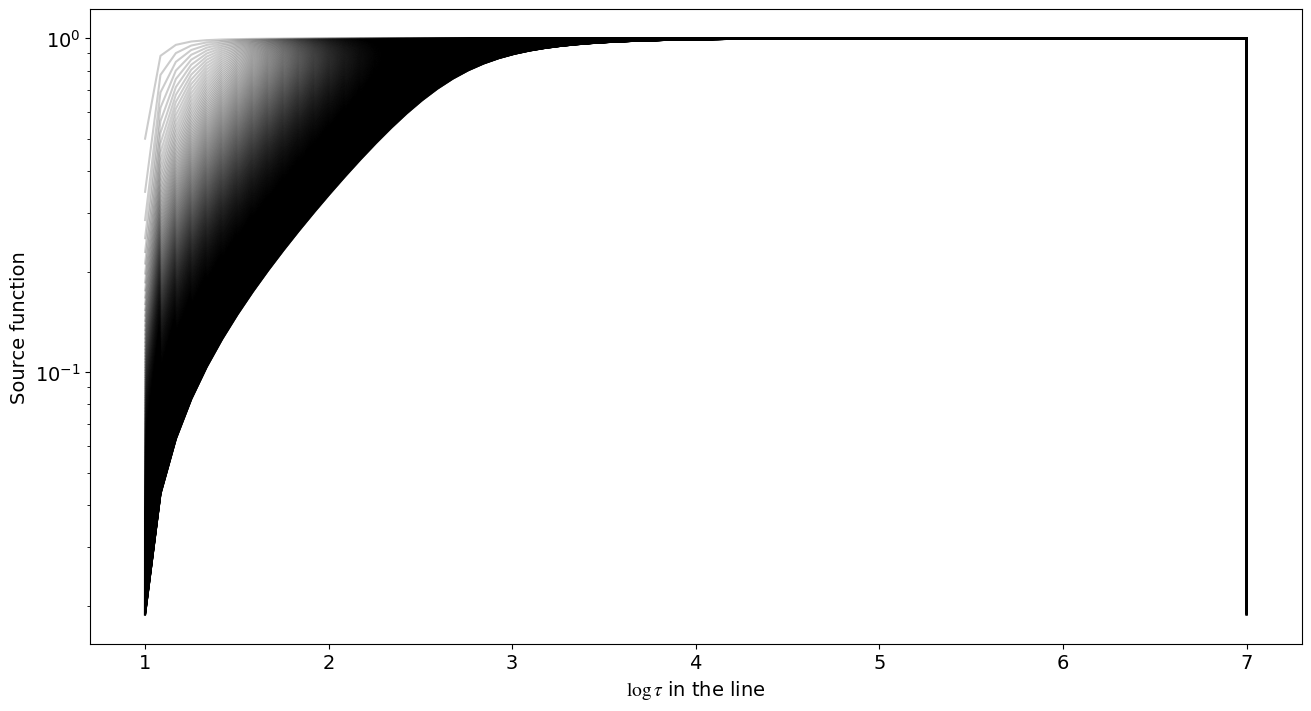

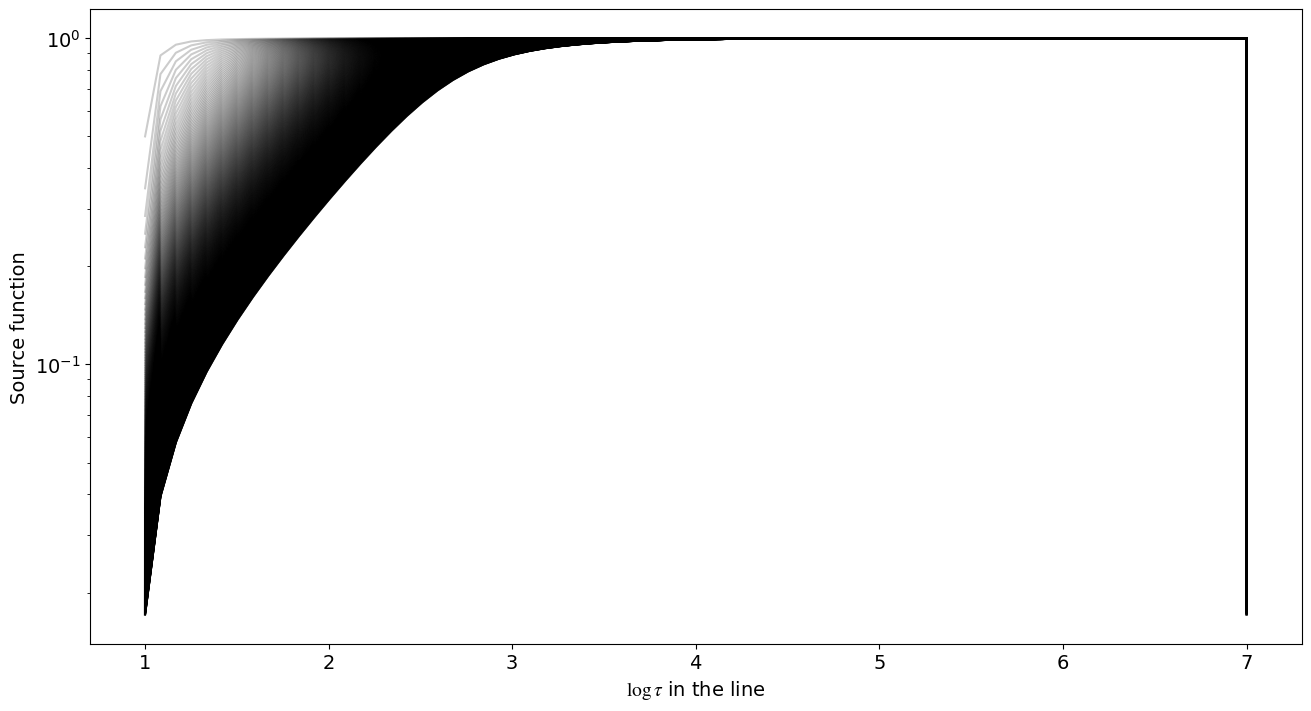

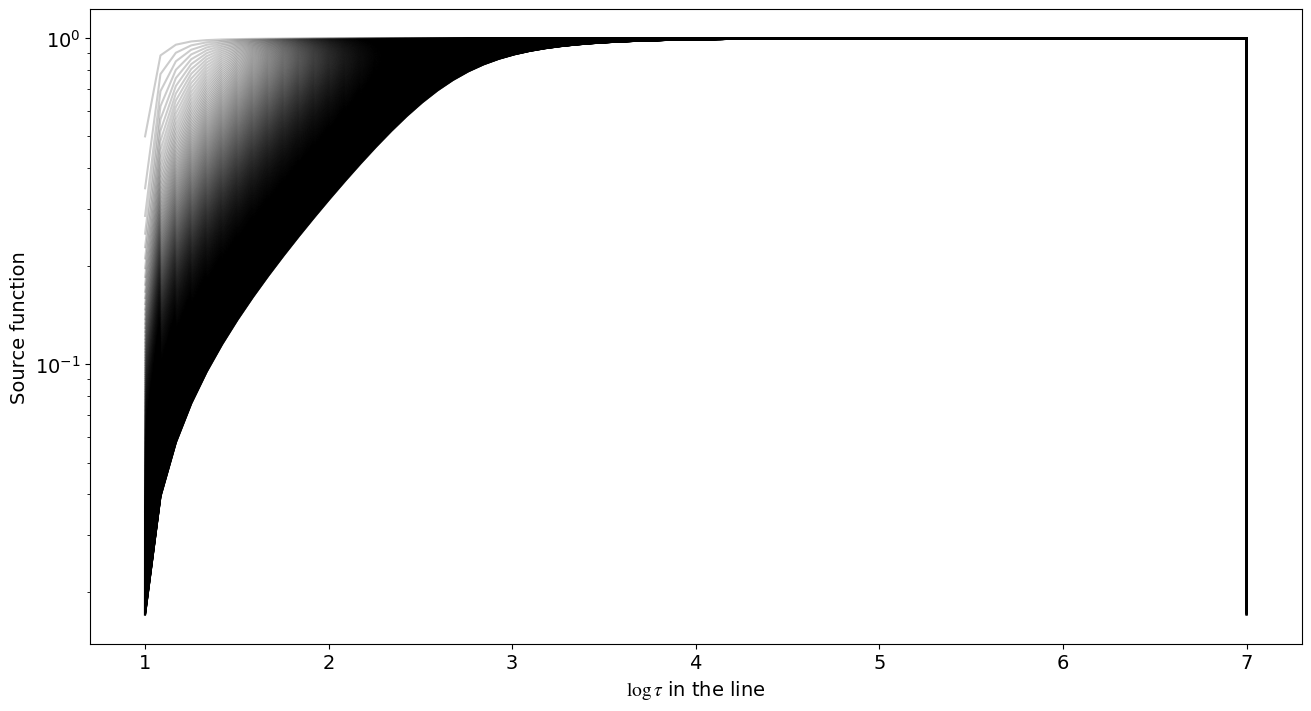

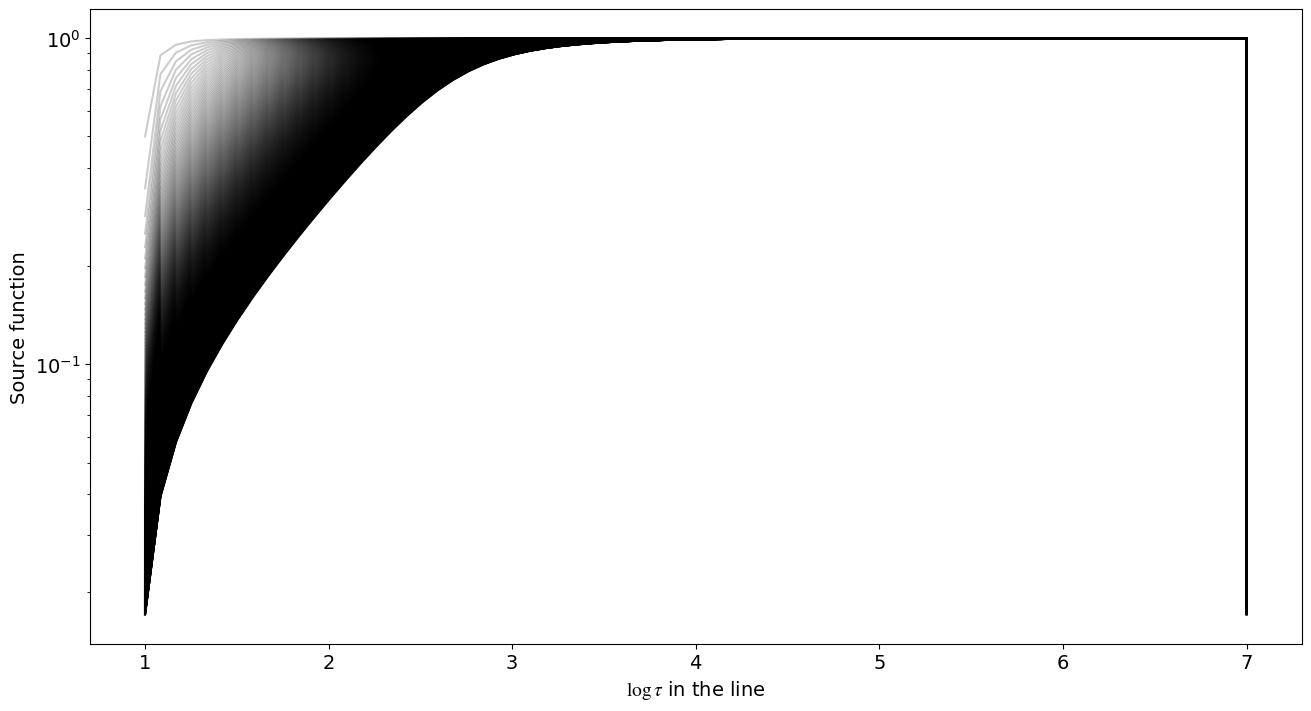

In [19]:
S_D_finite_e2_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-2, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e4_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e6_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-6, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e8_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-8, 1, low_bound = 0.0, up_bound = 0.0)
S_D_finite_e10_T4_LI = two_level_atom_LI(tau, 3, 121, 1.0, 1E-10, 1, low_bound = 0.0, up_bound = 0.0)

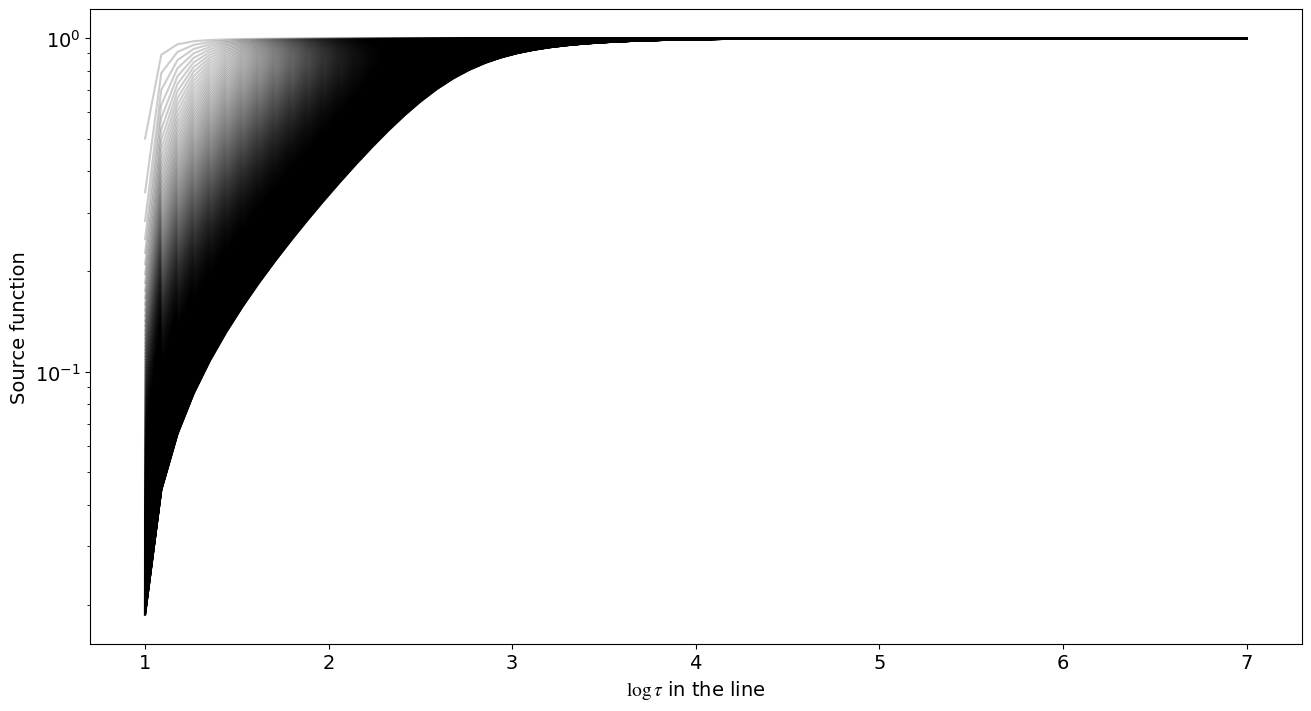

In [20]:
ltau_LI = np.linspace(-2, 4, 69)
tau_l_LI = 10**ltau_LI
S_D_e4_LI = two_level_atom_LI(tau_l_LI, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0)

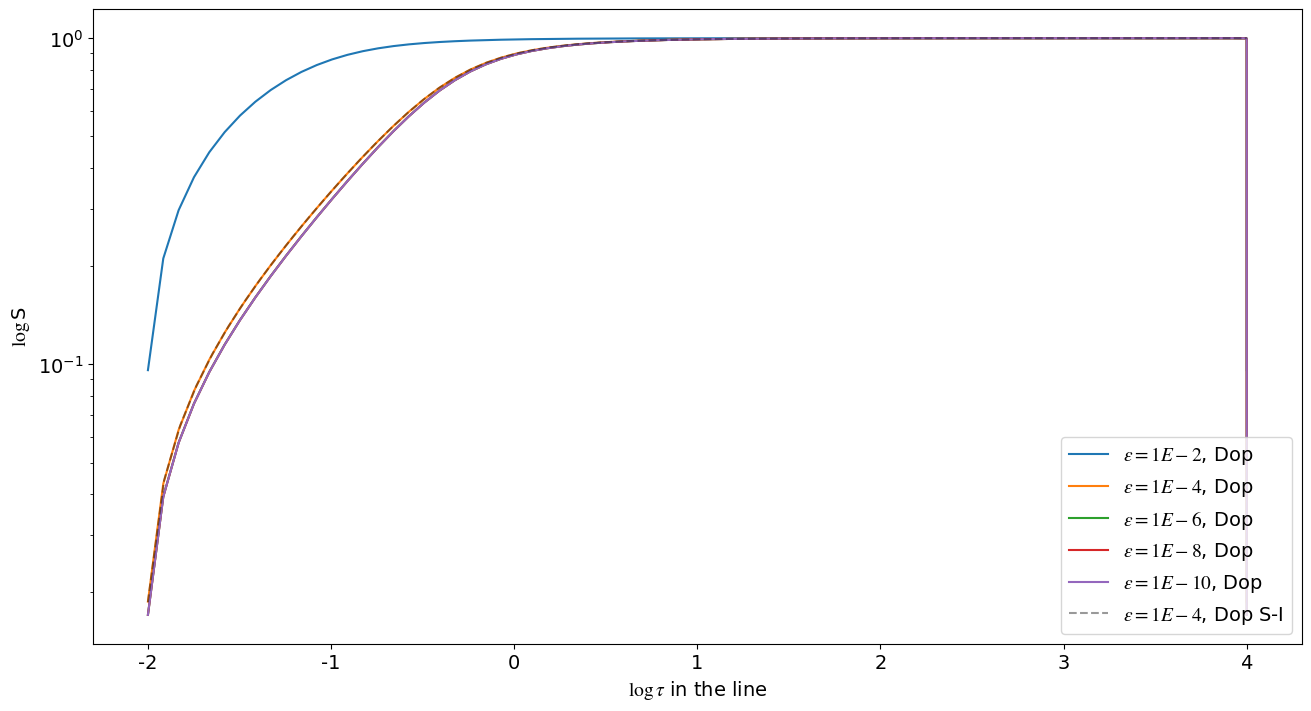

In [21]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau, S_D_finite_e2_T4_LI, label = "$\\varepsilon = 1E-2$, Dop")
plt.semilogy(logtau, S_D_finite_e4_T4_LI, label = "$\\varepsilon = 1E-4$, Dop")
plt.semilogy(logtau, S_D_finite_e6_T4_LI, label = "$\\varepsilon = 1E-6$, Dop")
plt.semilogy(logtau, S_D_finite_e8_T4_LI, label = "$\\varepsilon = 1E-8$, Dop")
plt.semilogy(logtau, S_D_finite_e10_T4_LI, label = "$\\varepsilon = 1E-10$, Dop")
plt.semilogy(ltau, S_D_e4_LI, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 1)

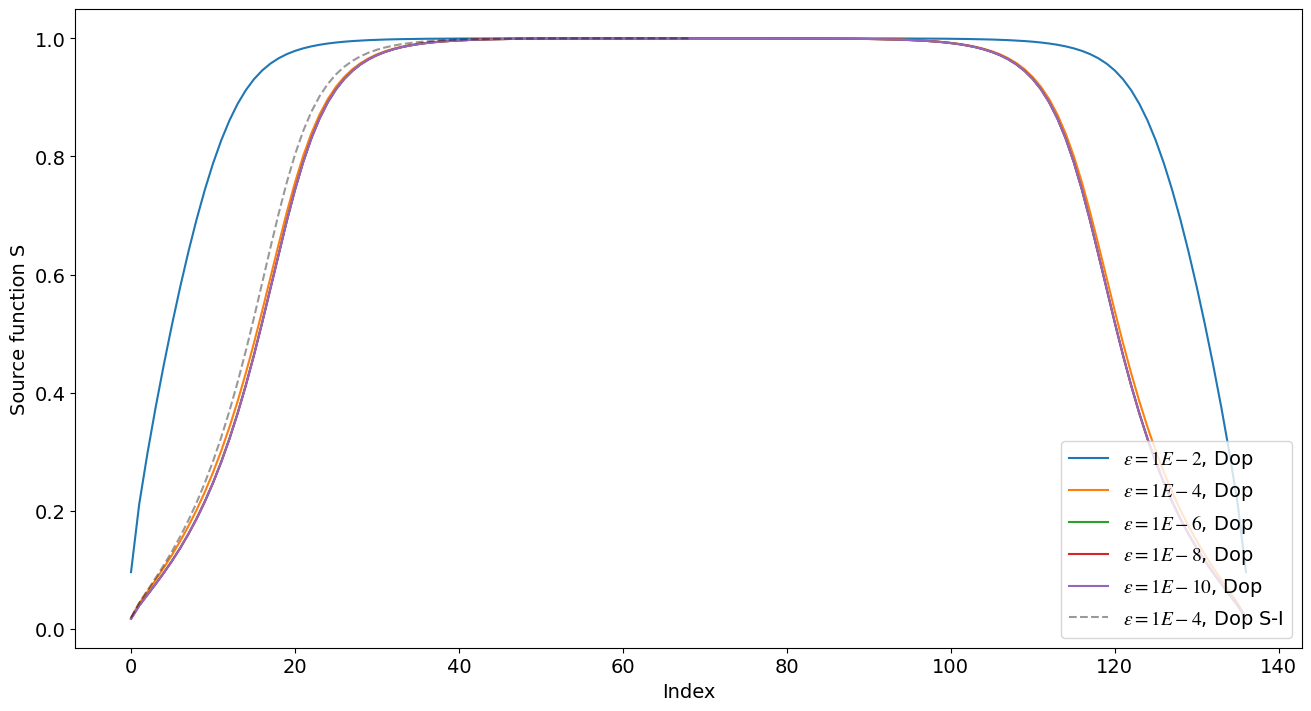

In [22]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("Index")
plt.ylabel("Source function S")
plt.plot(S_D_finite_e2_T4_LI, label = "$\\varepsilon = 1E-2$, Dop")
plt.plot(S_D_finite_e4_T4_LI, label = "$\\varepsilon = 1E-4$, Dop")
plt.plot(S_D_finite_e6_T4_LI, label = "$\\varepsilon = 1E-6$, Dop")
plt.plot(S_D_finite_e8_T4_LI, label = "$\\varepsilon = 1E-8$, Dop")
plt.plot(S_D_finite_e10_T4_LI, label = "$\\varepsilon = 1E-10$, Dop")
plt.plot(S_D_e4_LI, alpha = 0.4, linestyle = "--", color = "black", label = "$\\varepsilon = 1E-4$, Dop S-I")
plt.legend(loc = "lower right", ncols = 1)

In [23]:
S_D_finite_e6_T4_LI_diff = element_difference(S_D_finite_e6_T4_LI)
print(S_D_finite_e6_T4_LI_diff)

[ 5.84959164e-13 -5.84959164e-13  5.81563270e-12  2.21760804e-12
 -1.58760505e-12  3.60600438e-12 -4.68791672e-14 -1.63502545e-12
  1.04224962e-12  3.01059178e-12  5.51420021e-13  1.37120870e-12
 -1.31494815e-12 -7.13873405e-13  8.90953977e-14  6.06181771e-13
  1.58428826e-13  1.48470125e-12  5.92859095e-13 -2.03725925e-13
 -3.58379992e-13 -1.12798659e-13 -4.34097203e-14  8.27116153e-14
  9.00390873e-14 -5.08482145e-14  3.73034936e-14 -6.66133815e-16
  2.50910404e-14  8.10462808e-15 -2.15383267e-14  2.22044605e-16
  1.77635684e-15 -5.55111512e-16  7.43849426e-15  5.10702591e-15
  2.35367281e-14  5.99520433e-15  2.38697950e-14  8.88178420e-16
  9.99200722e-16 -4.44089210e-16  2.29816166e-14  2.34257058e-14
 -1.26565425e-14  5.55111512e-15 -4.99600361e-15 -2.14273044e-14
  4.55191440e-15 -3.44169138e-15  1.11022302e-16  0.00000000e+00
  2.99760217e-15  6.32827124e-15 -2.22044605e-16 -1.11022302e-16
  9.99200722e-16 -2.38697950e-14  1.11022302e-16  1.34336986e-14
  1.19904087e-14  2.64233

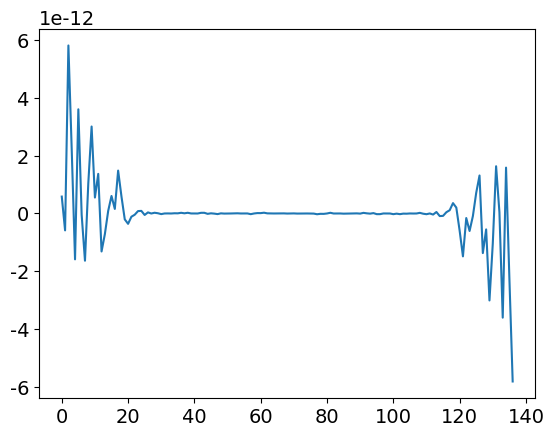

In [24]:
plt.plot(S_D_finite_e6_T4_LI_diff)

2.0
1.6989700043360187
21
0.08494850021680093
4.0
3.6989700043360187
45
0.08406750009854588
6.0
5.698970004336019
69
0.08380838241670616
8.0
7.698970004336019
93
0.08368445656886978
4.0
3.6989700043360187
45
0.08406750009854588


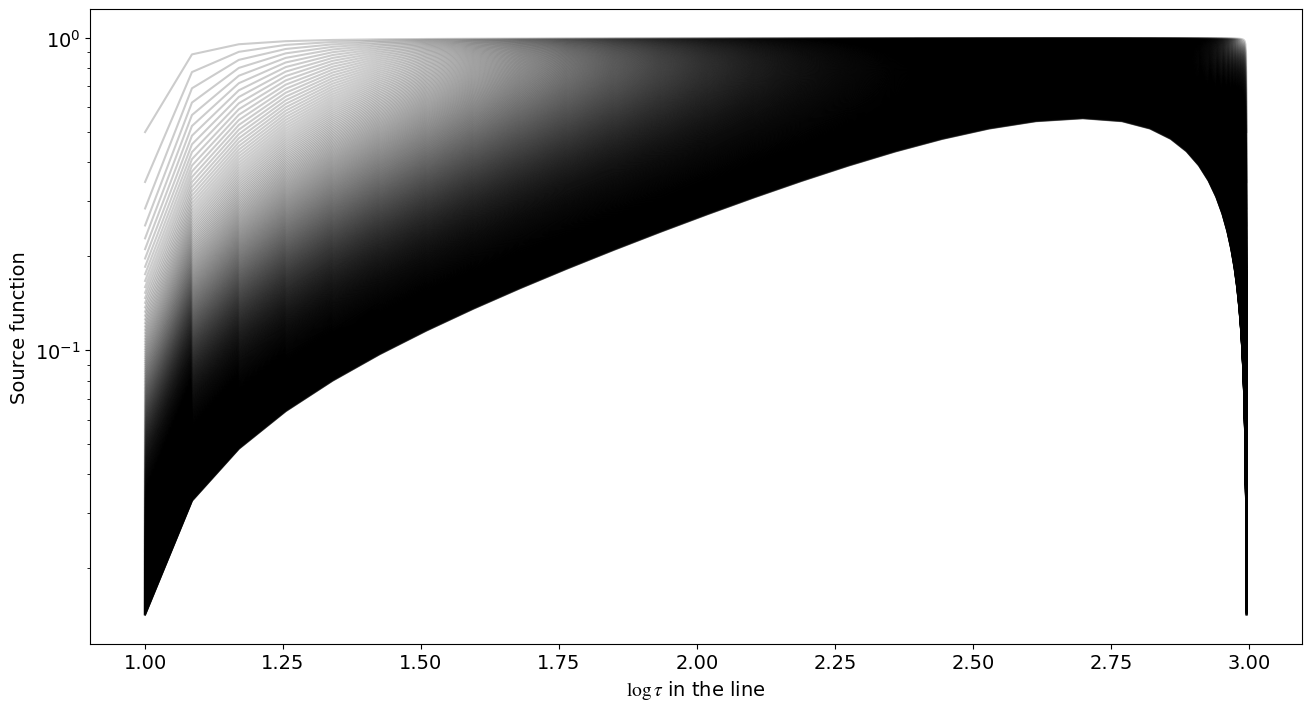

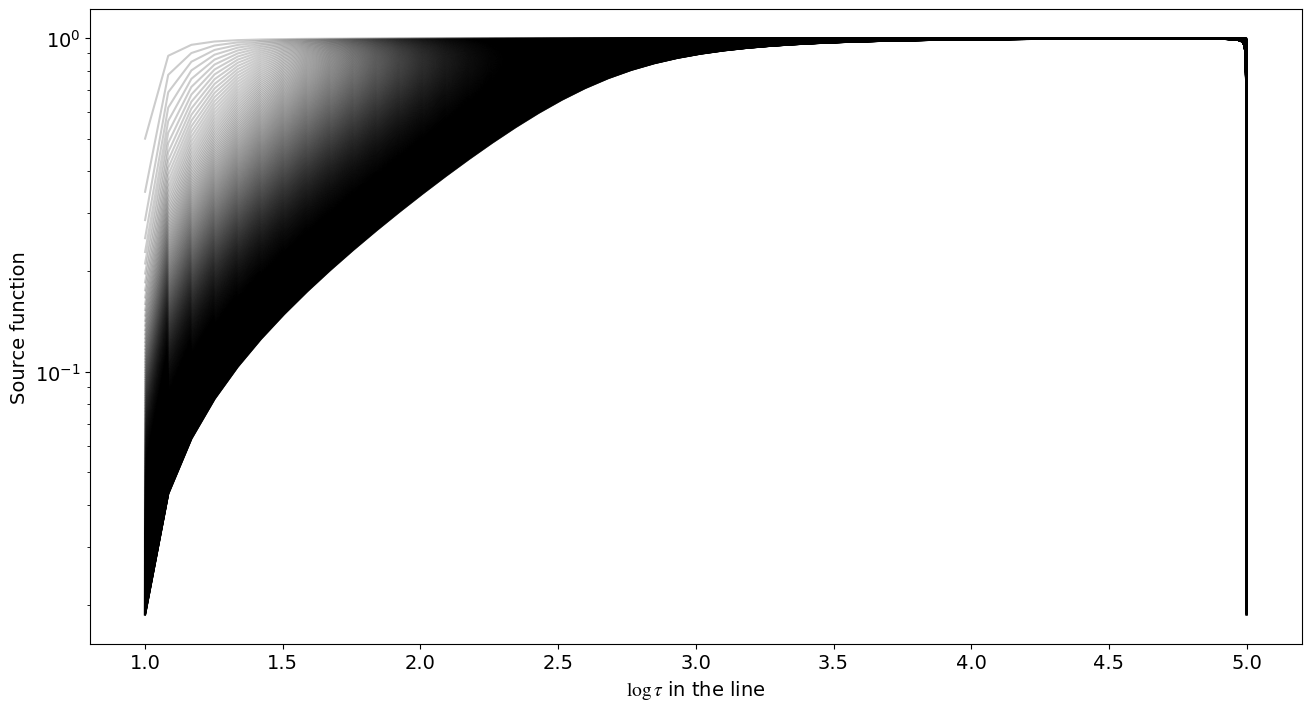

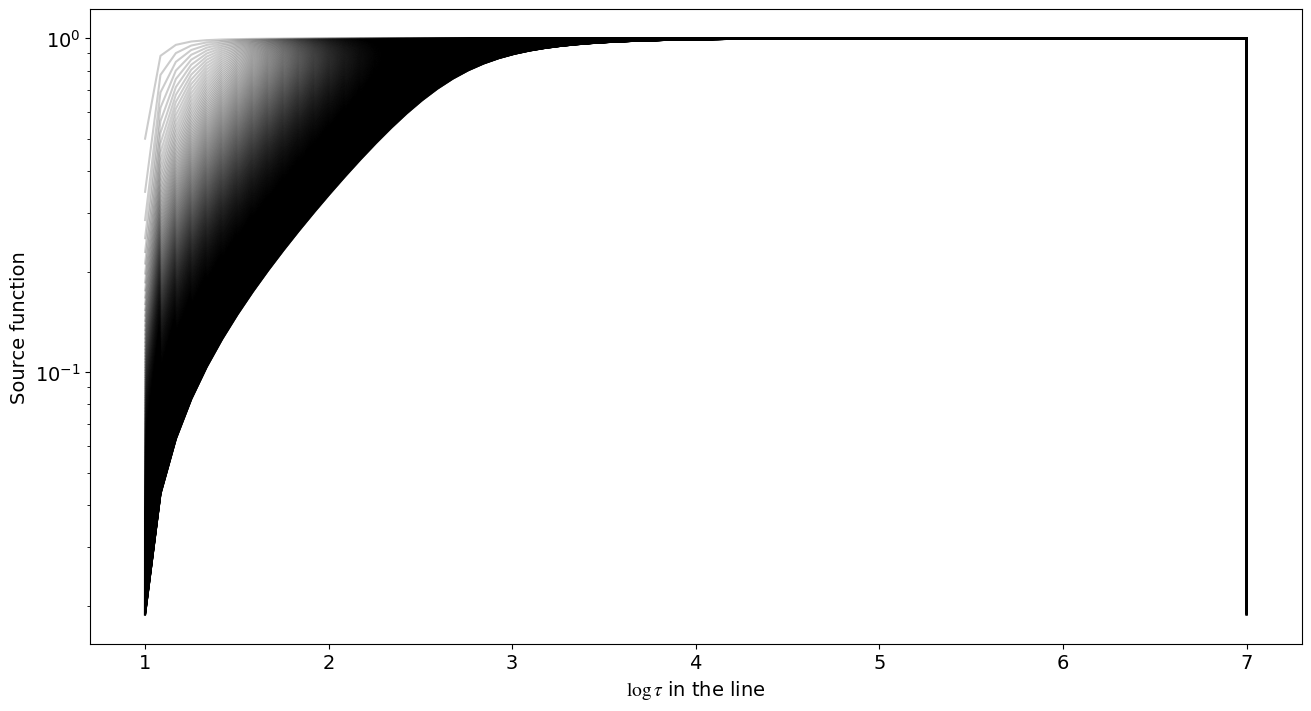

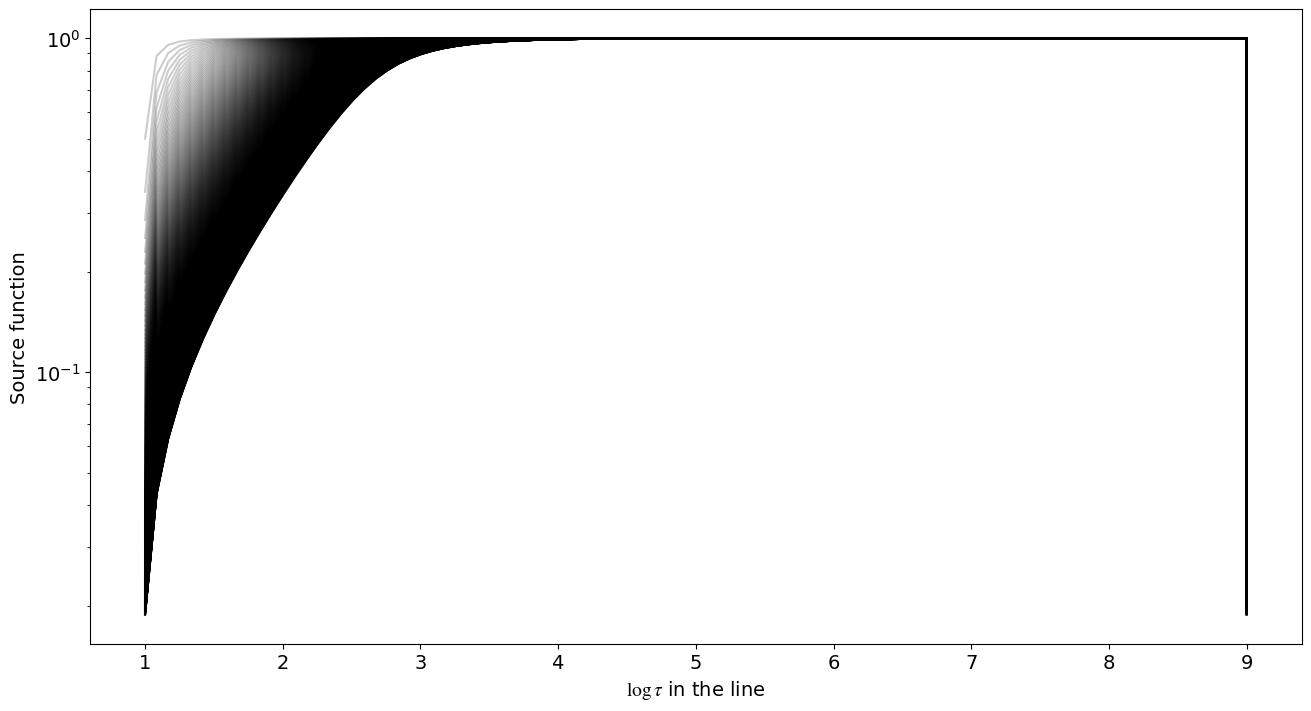

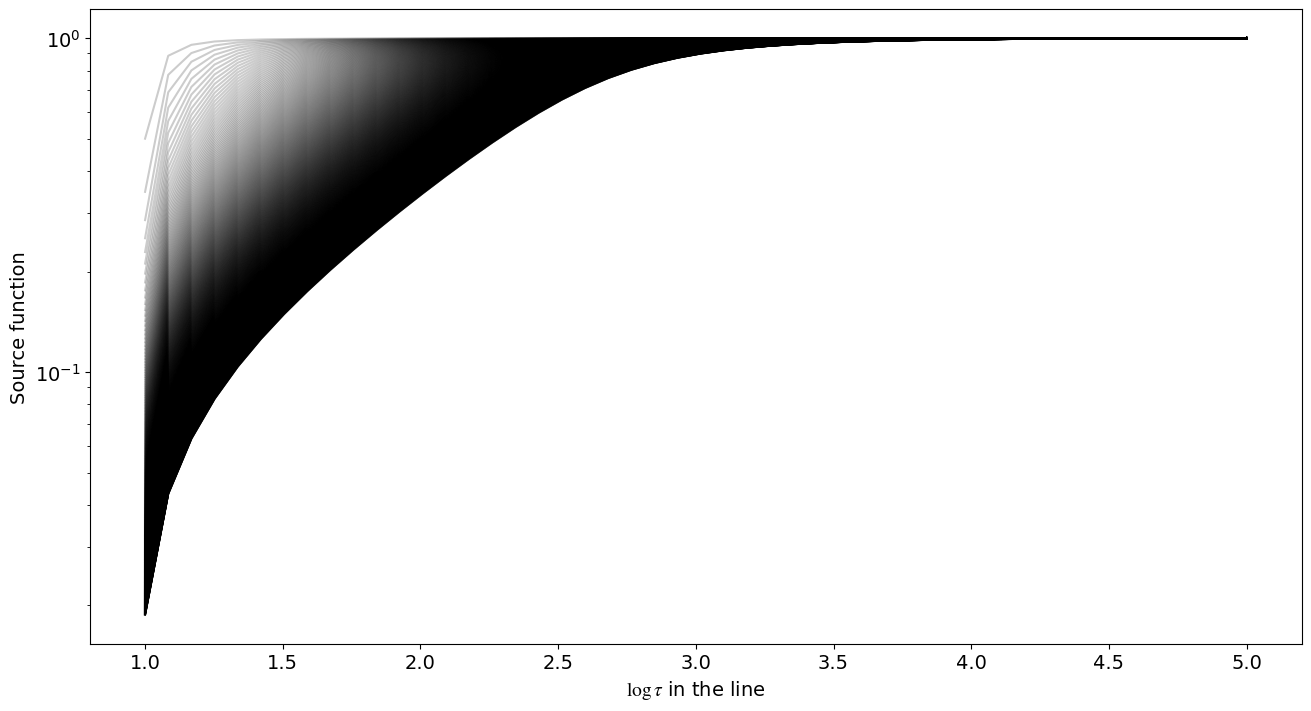

In [25]:
# How about intensity??
lratio = 1E3
x = np.linspace(-6, 6, 121)
profile = 1/np.sqrt(np.pi) * np.exp(-(x**2))

tau2 = tau_grid(1E-2, 1, 12)
S_D_finite_e4_T2_LI = two_level_atom_LI(tau2, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
#print(S_D_finite_e4_T2)
I_out2_LI = one_full_fs(tau2*lratio,S_D_finite_e4_T2_LI,1.0,profile,S_D_finite_e4_T2_LI[-1])

tau4 = tau_grid(1E-2, 1E2, 12)
S_D_finite_e4_T4_LI = two_level_atom_LI(tau4, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out4_LI = one_full_fs(tau4*lratio,S_D_finite_e4_T4_LI,1.0,profile,S_D_finite_e4_T4_LI[-1])

tau6 = tau_grid(1E-2, 1E4, 12)
S_D_finite_e4_T6_LI = two_level_atom_LI(tau6, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out6_LI = one_full_fs(tau6*lratio,S_D_finite_e4_T6_LI,1.0,profile,S_D_finite_e4_T6_LI[-1])

tau8 = tau_grid(1E-2, 1E6, 12)
S_D_finite_e4_T8_LI = two_level_atom_LI(tau8, 3, 121, 1.0, 1E-4, 1, low_bound = 0.0, up_bound = 0.0, lratio = 1E3)
I_out8_LI = one_full_fs(tau8*lratio,S_D_finite_e4_T8_LI,1.0,profile,S_D_finite_e4_T8_LI[-1])

taui = tau_grid(1E-2, 1E2, 12)
S_D_e4_LI = two_level_atom_LI(taui, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
I_outinf_LI = one_full_fs(taui*lratio,S_D_e4_LI,1.0,profile,S_D_e4_LI[-1])

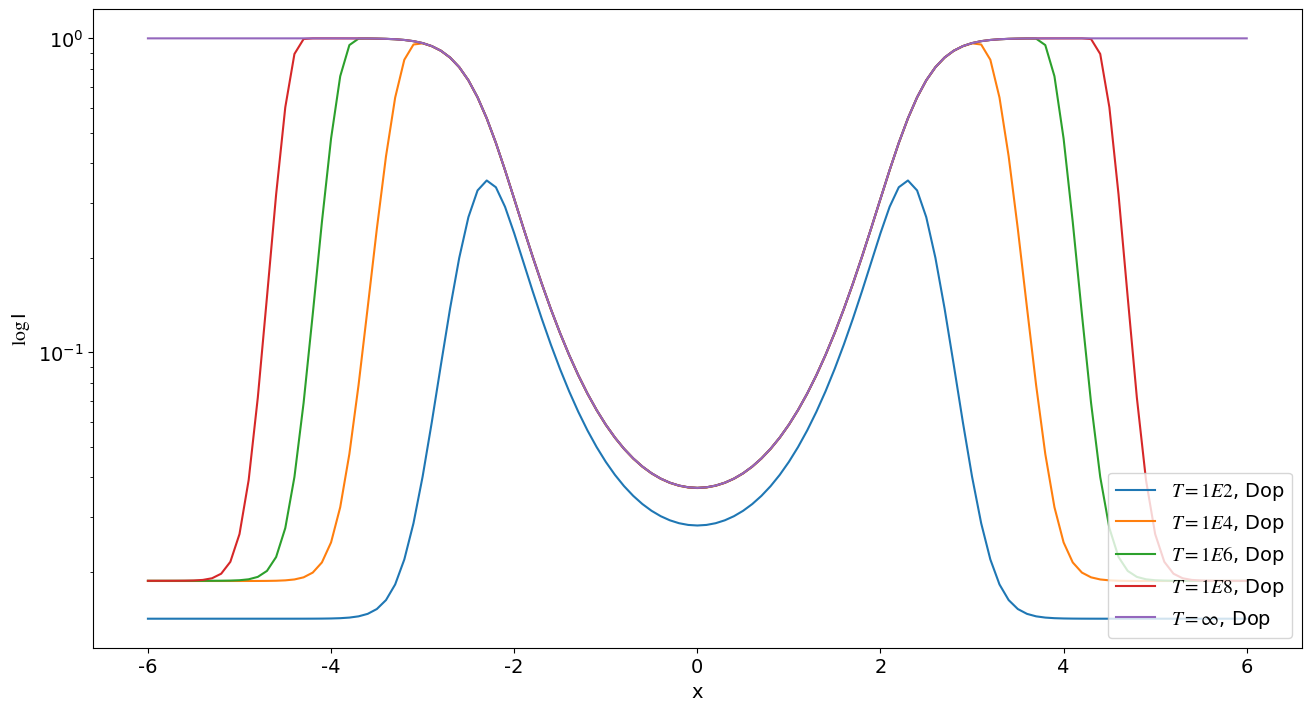

In [26]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("x")
#plt.xlim(0,5)
plt.ylabel("$\\log$I")
plt.semilogy(x, I_out2_LI, label = "$T = 1E2$, Dop")
plt.semilogy(x, I_out4_LI, label = "$T = 1E4$, Dop")
plt.semilogy(x, I_out6_LI, label = "$T = 1E6$, Dop")
plt.semilogy(x, I_out8_LI, label = "$T = 1E8$, Dop")
plt.semilogy(x, I_outinf_LI, label = "$T = \infty$, Dop")
plt.legend(loc = "lower right", ncols = 1)

<h2>Semi-infinite atmosphere</h2>
<p>Just to be sure, we also want to be able to recover the semi-infinite atmosphere case, i.e. <b><i>Fig. 11.1</i></b> and <b><i>Fig. 11.2</i></b>.</p>

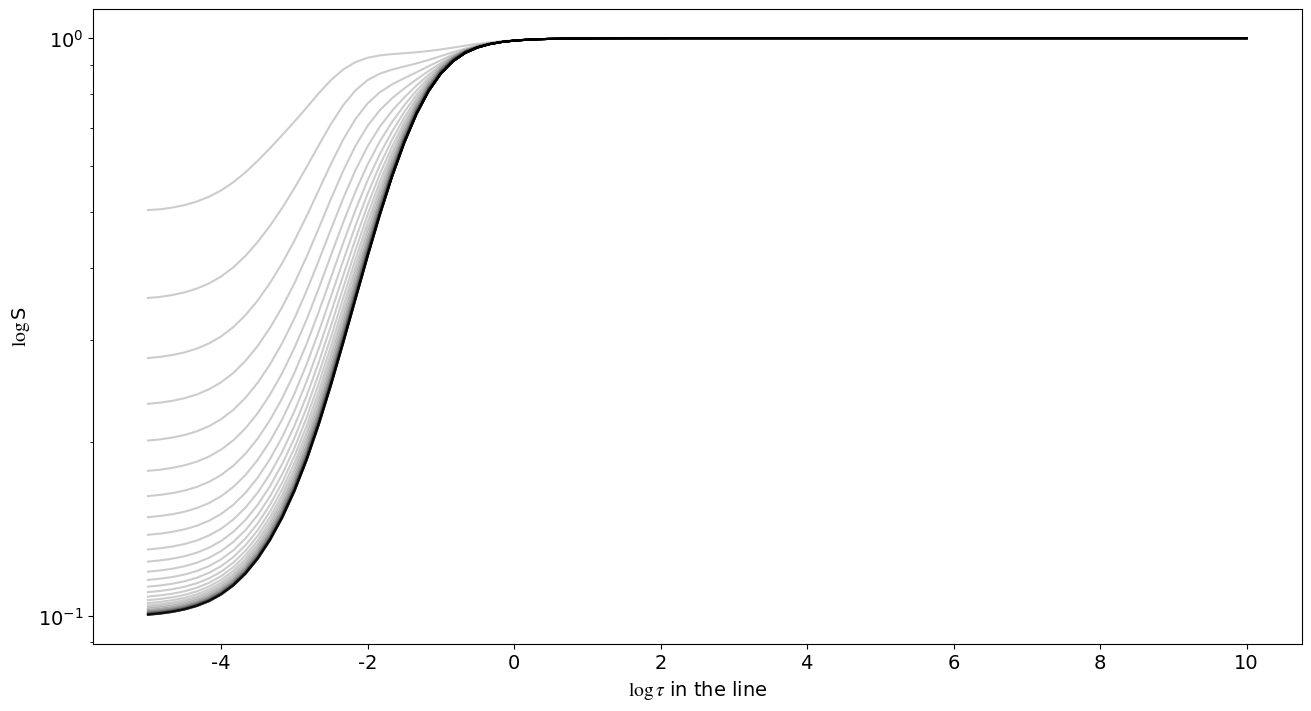

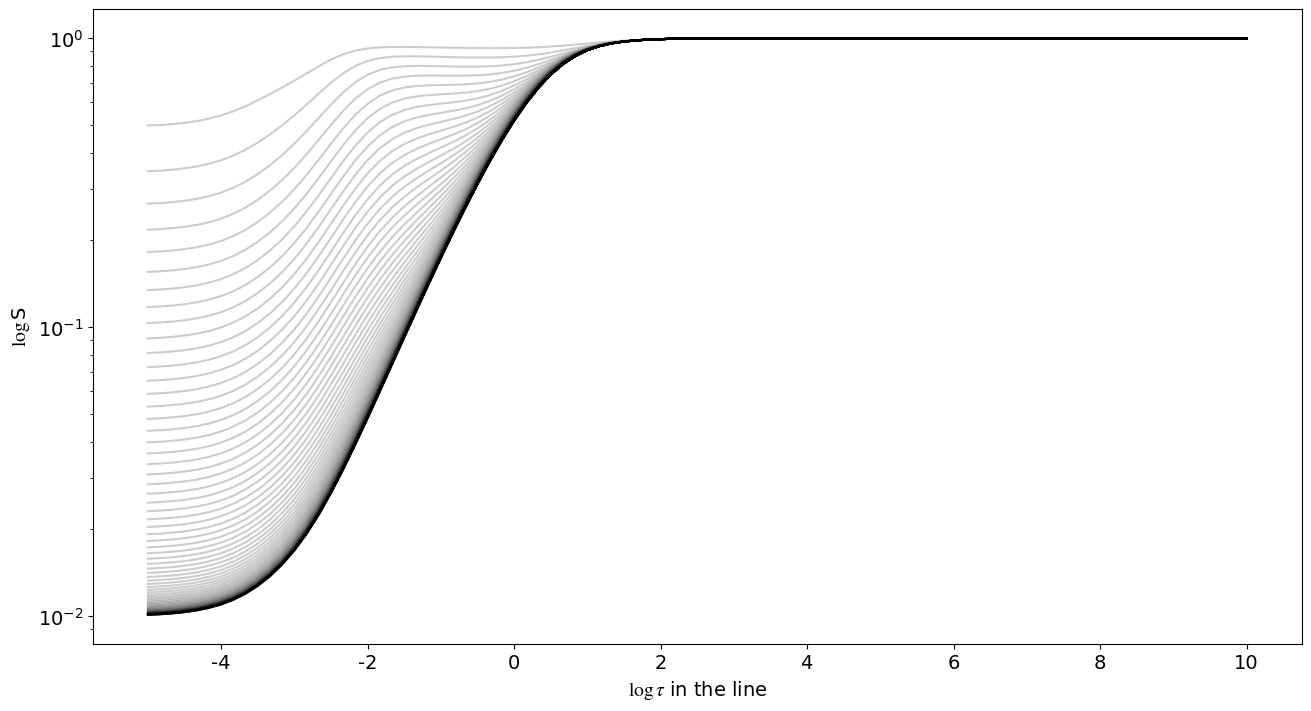

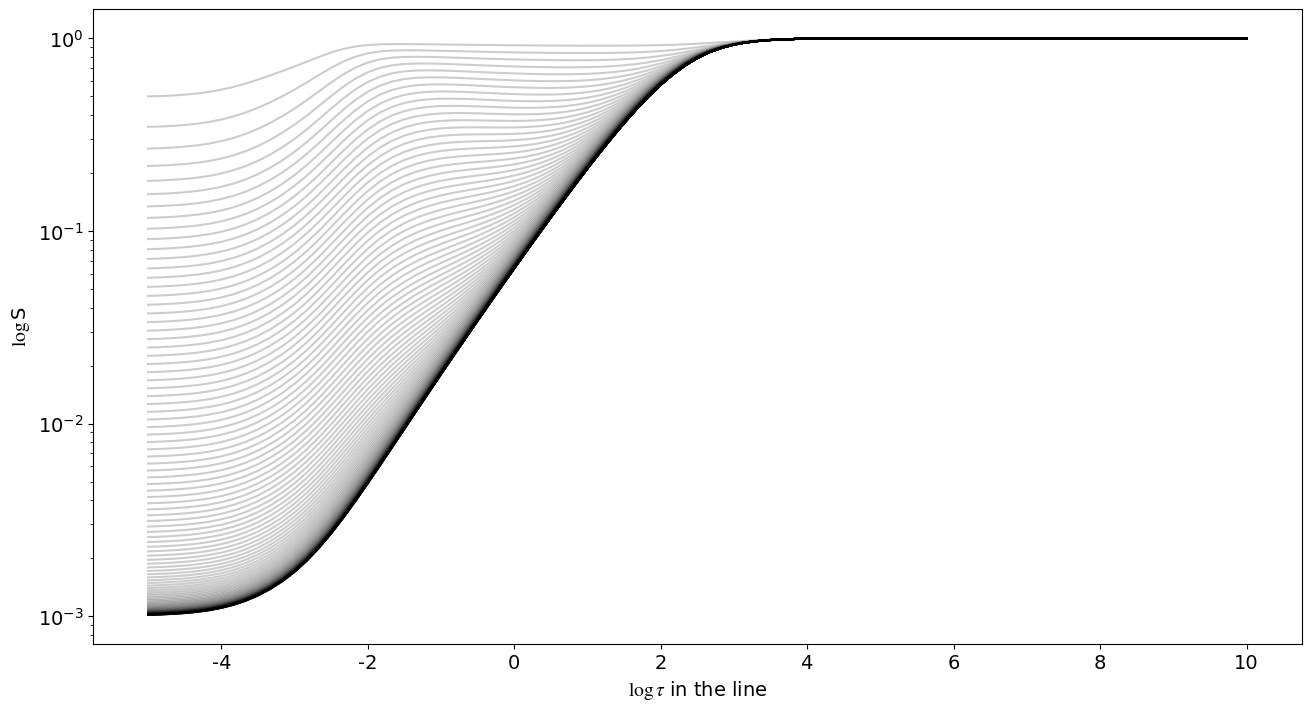

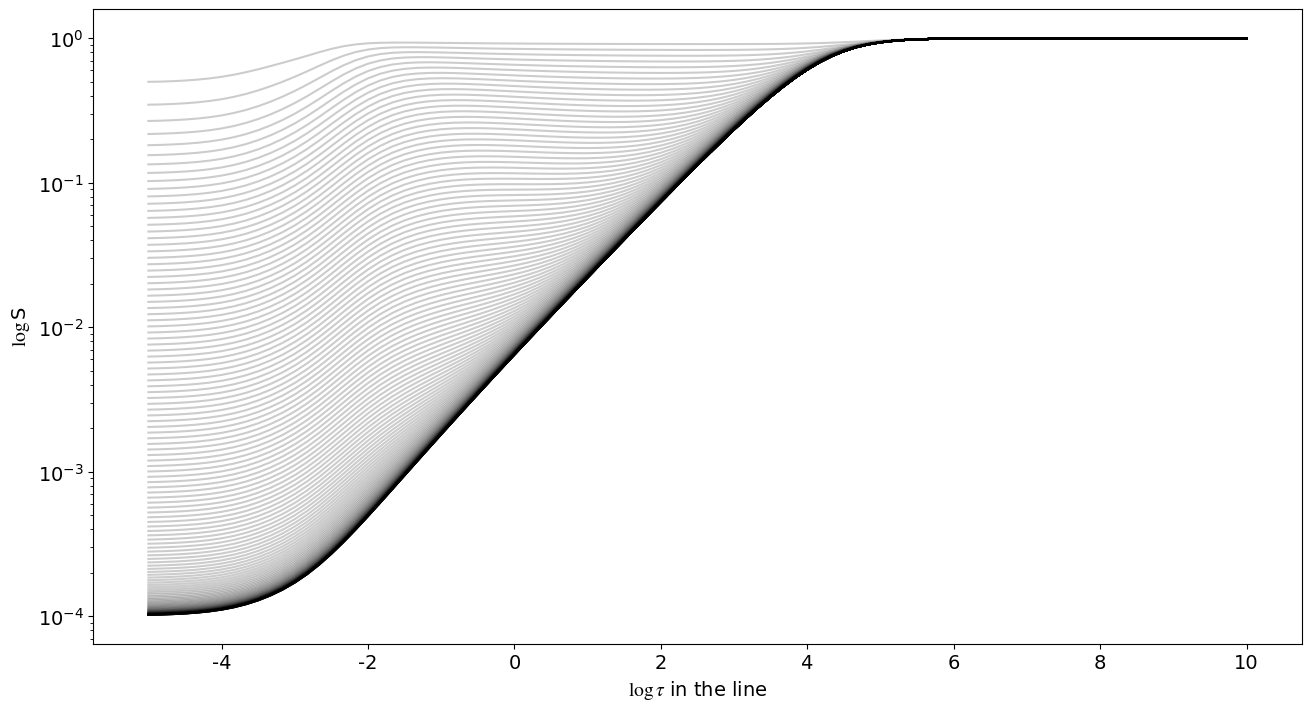

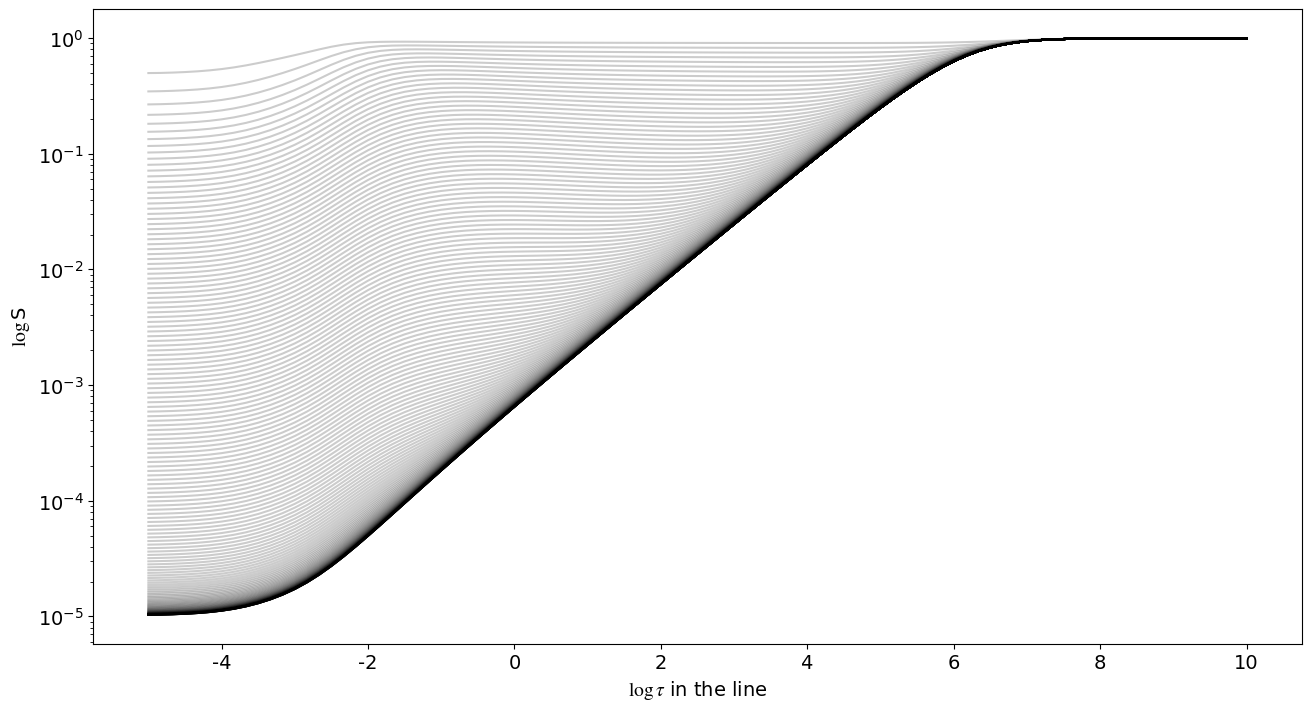

In [27]:
logtau_mock = np.linspace(-5, 10, 91)
tau_mock = 10**logtau_mock
#tau_mock = tau_grid(1E-2, 1E7, 12)
#logtau_mock = np.log10(tau_mock)
S_mock2 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-2, 1, low_bound = 1.0, up_bound = 0.0)
S_mock4 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-4, 1, low_bound = 1.0, up_bound = 0.0)
S_mock6 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0)
S_mock8 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-8, 1, low_bound = 1.0, up_bound = 0.0)
S_mock10 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-10, 1, low_bound = 1.0, up_bound = 0.0)

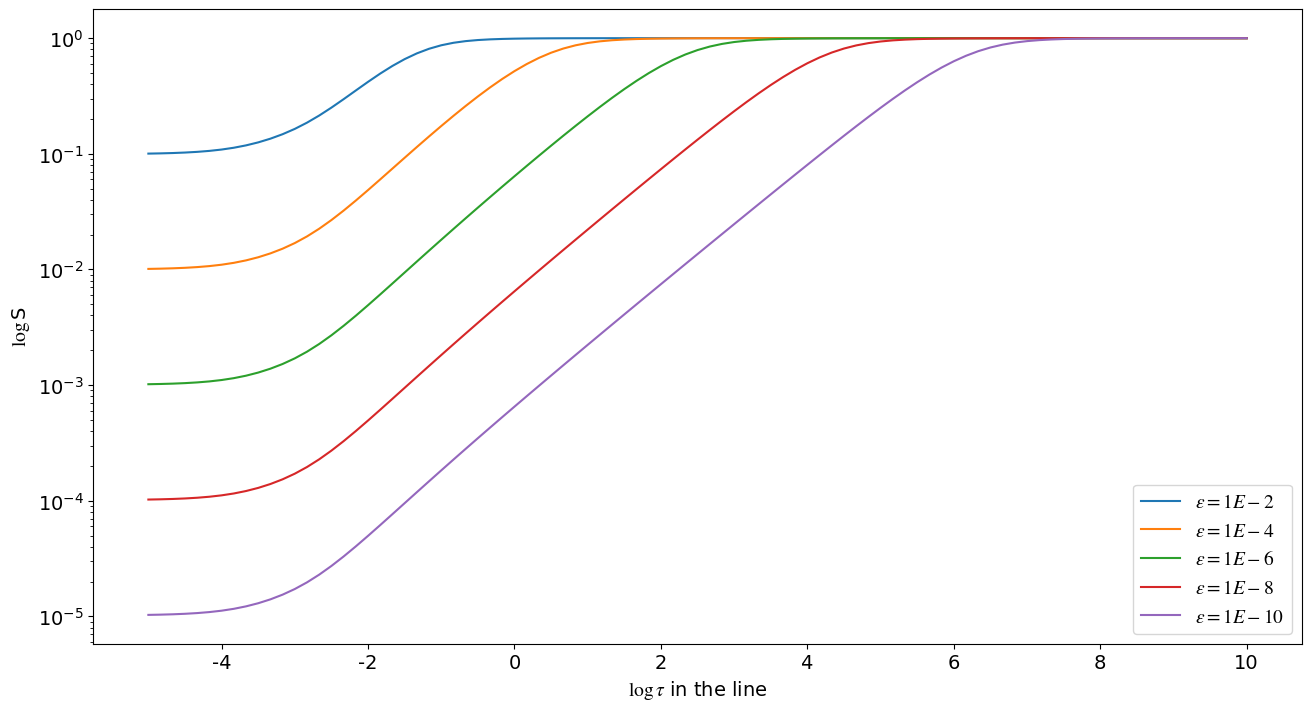

In [28]:
plt.figure(constrained_layout = True, figsize = (13,7))
plt.xlabel("$\\log\\tau$ in the line")
plt.ylabel("$\\log$S")
plt.semilogy(logtau_mock, S_mock2, label = "$\\varepsilon = 1E-2$")
plt.semilogy(logtau_mock, S_mock4, label = "$\\varepsilon = 1E-4$")
plt.semilogy(logtau_mock, S_mock6, label = "$\\varepsilon = 1E-6$")
plt.semilogy(logtau_mock, S_mock8, label = "$\\varepsilon = 1E-8$")
plt.semilogy(logtau_mock, S_mock10, label = "$\\varepsilon = 1E-10$")
plt.legend()

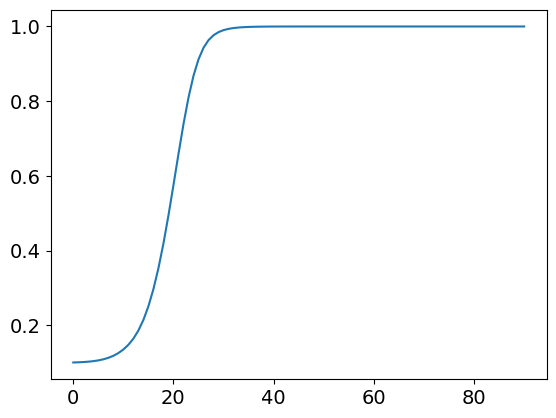

In [29]:
plt.plot(S_mock2)

<h3>What if we change line_ratio (lratio)??</h3>
<p>Here we want to see the impact of line_ratio parameter on the source function. Our goal is to reproduce <b><i>Fig. 11.5</i></b>
from Mihalas.</p>

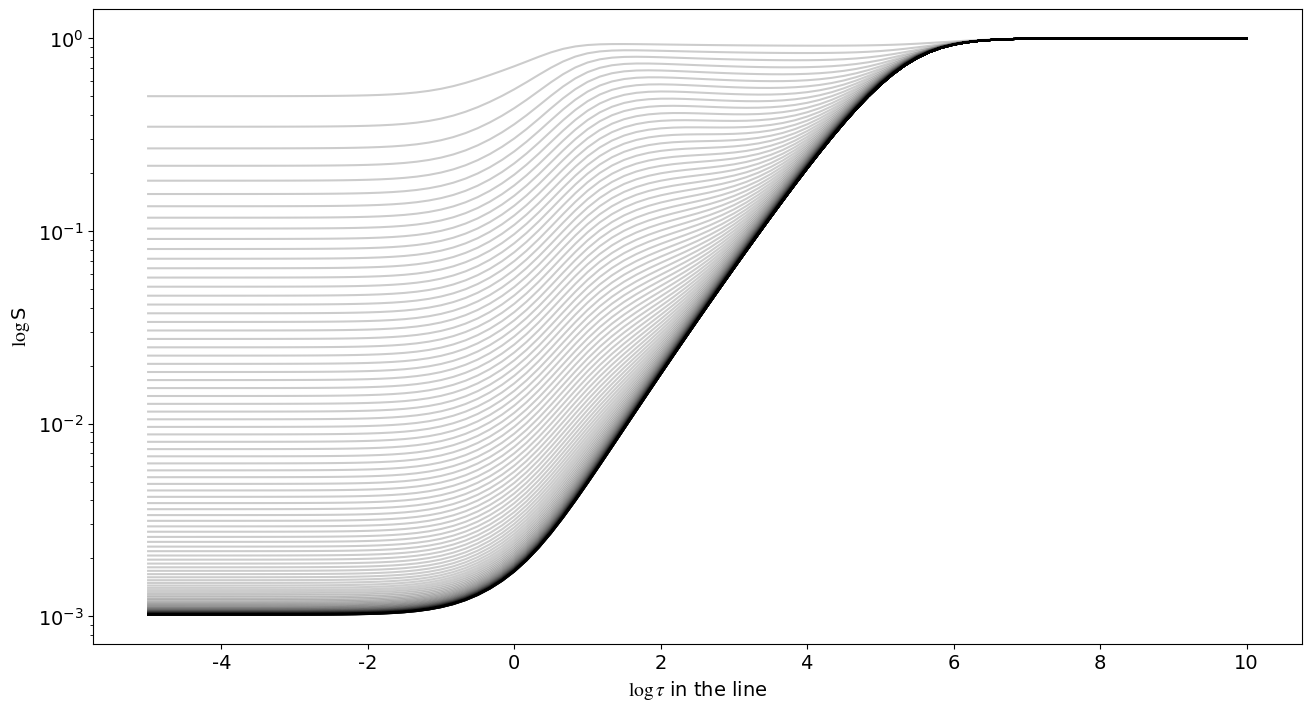

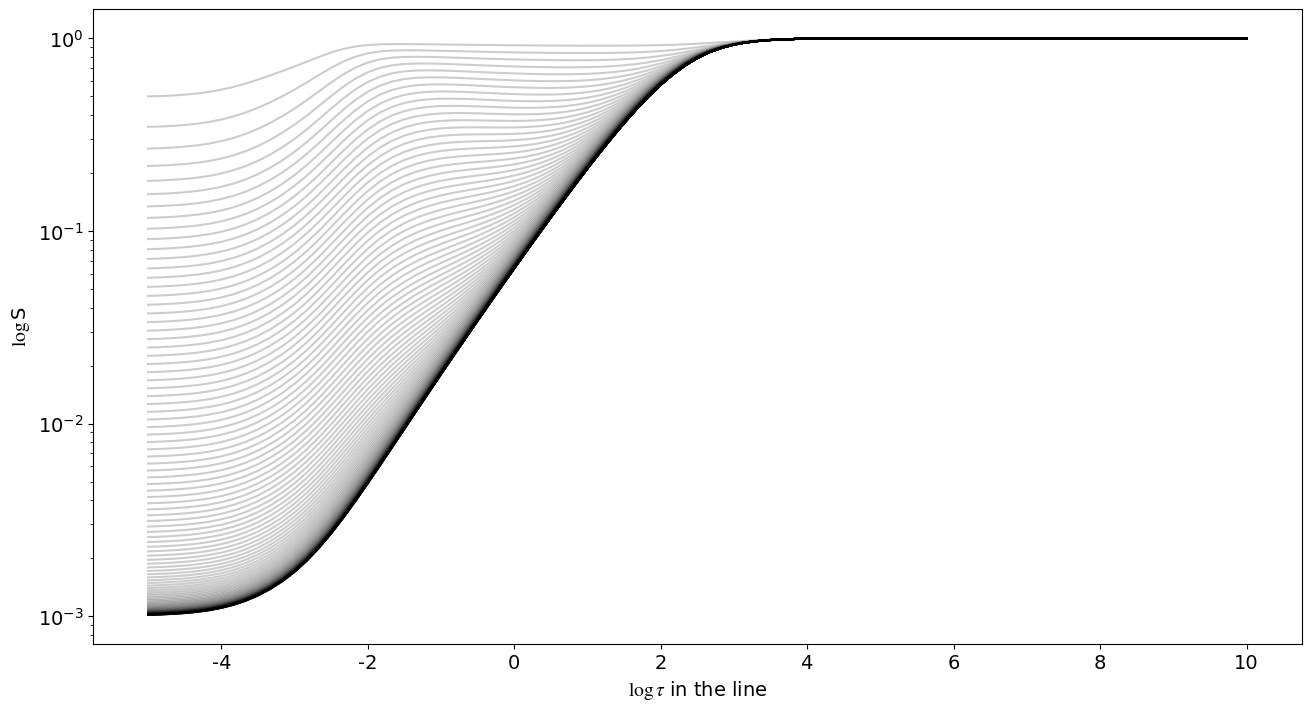

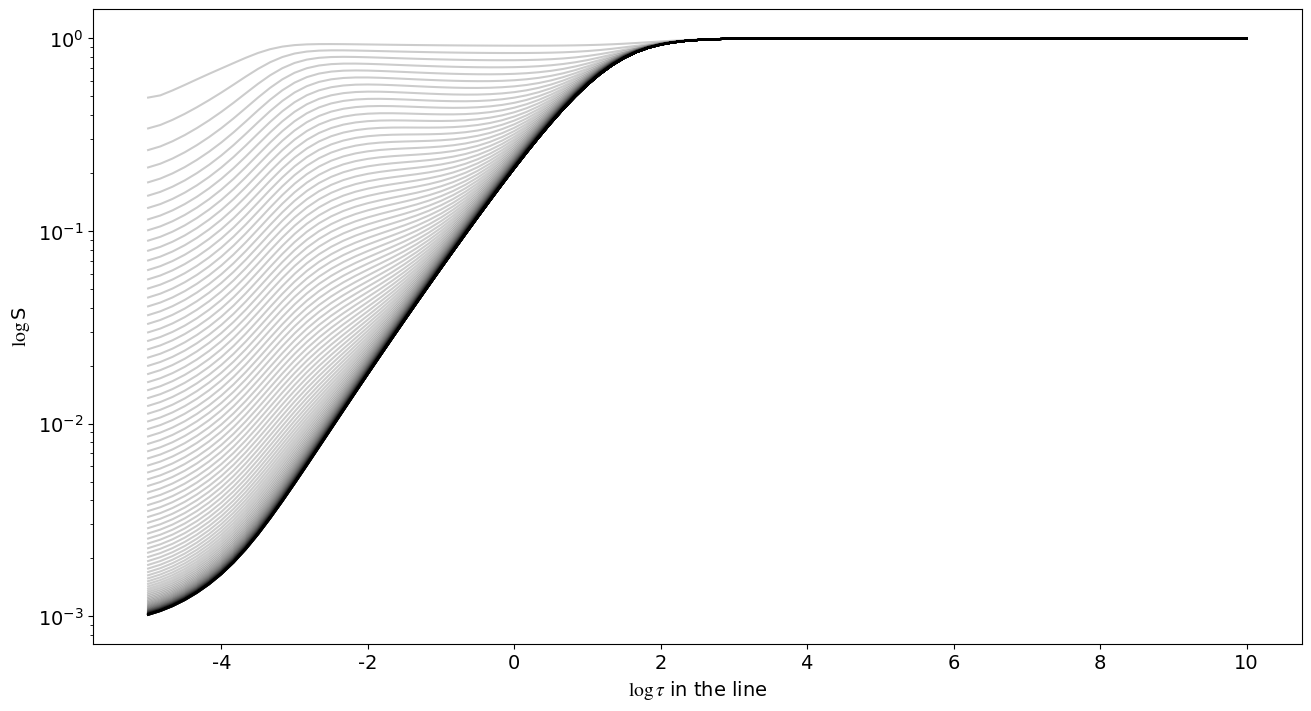

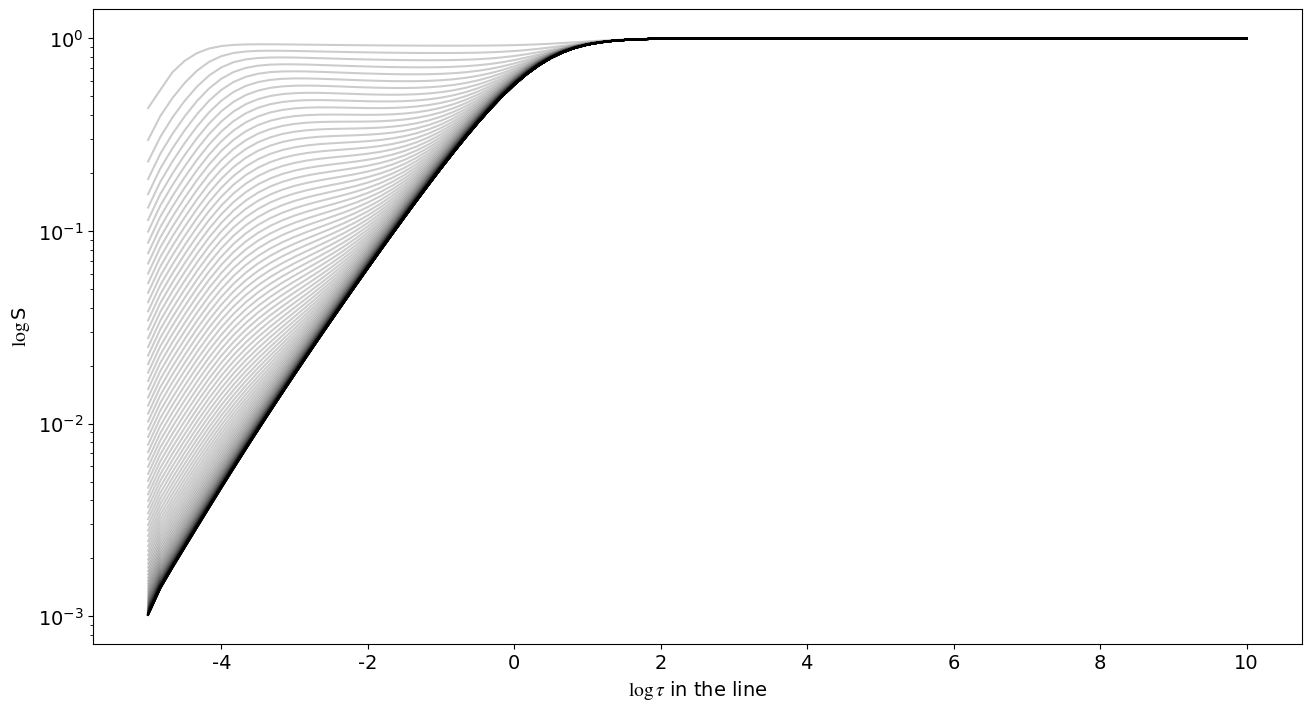

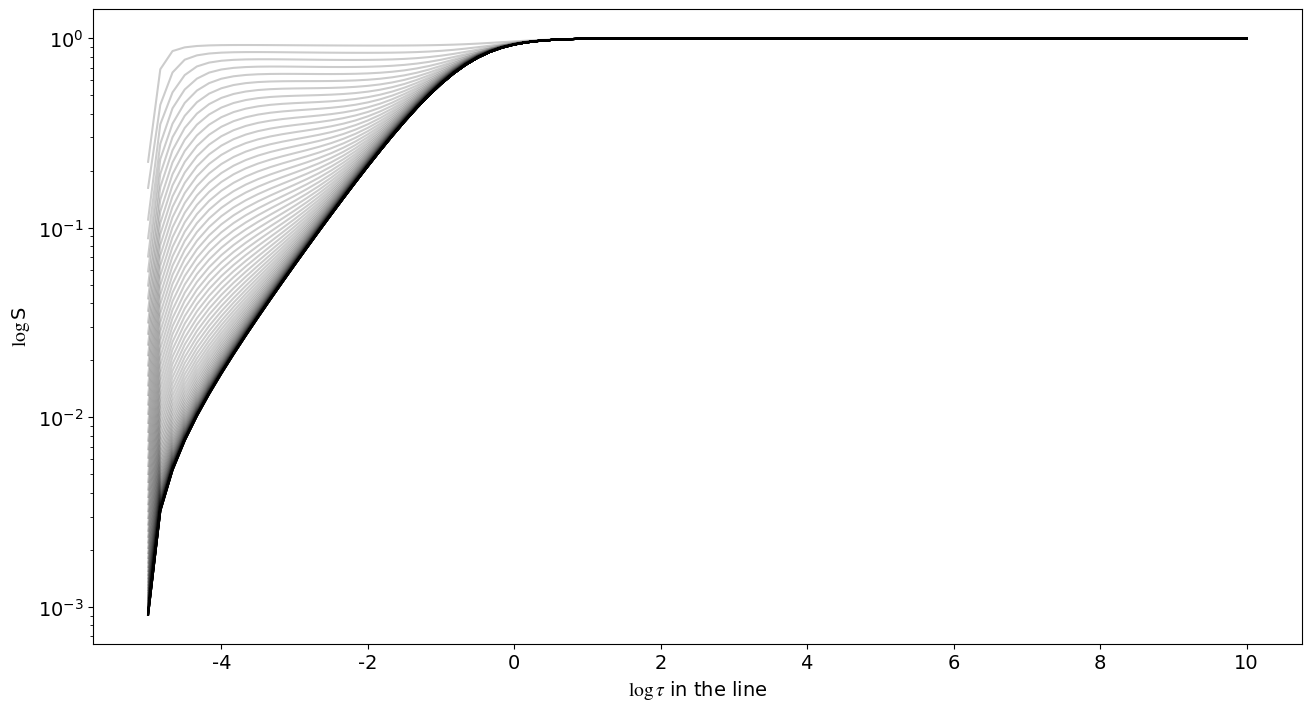

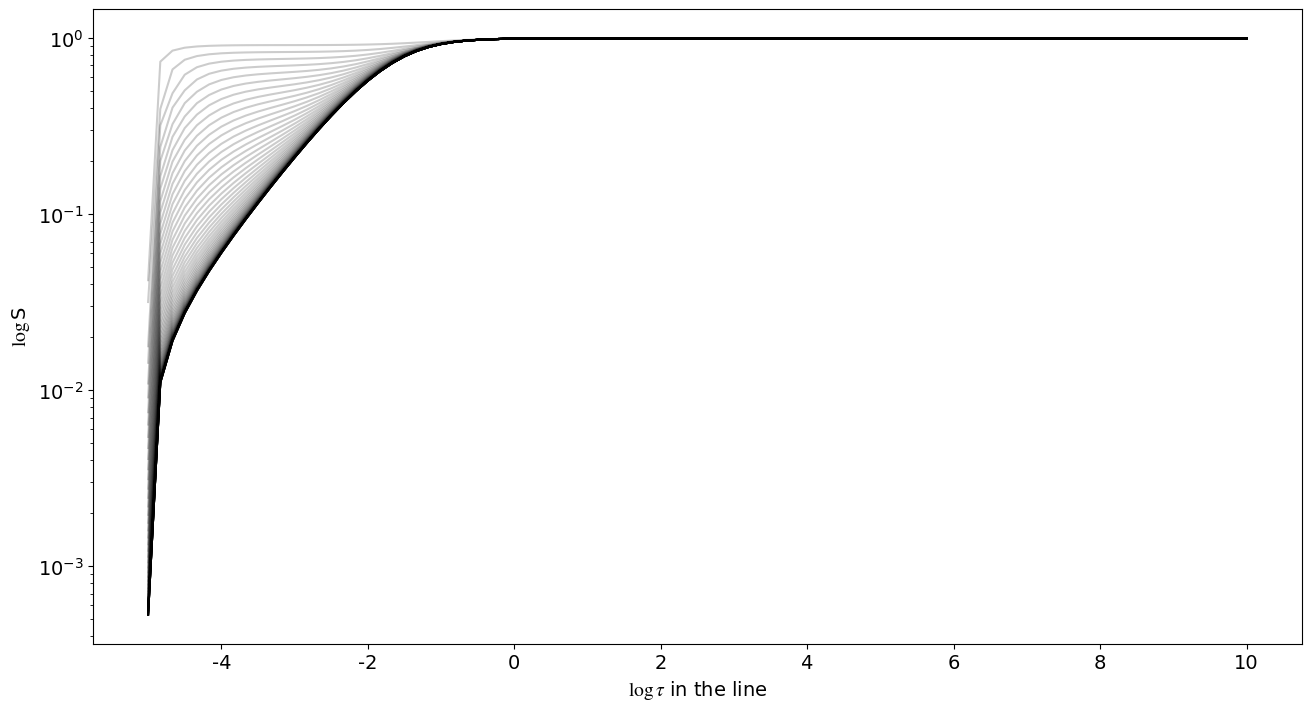

In [30]:
S_mockr1 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1)
S_mockr3 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E3)
S_mockr4 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E4)
S_mockr5 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E5)
S_mockr6 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E6)
S_mockr7 = two_lvl_nlte_solver(tau_mock, 3, 121, 1.0, 1E-6, 1, low_bound = 1.0, up_bound = 0.0, lratio = 1E7)

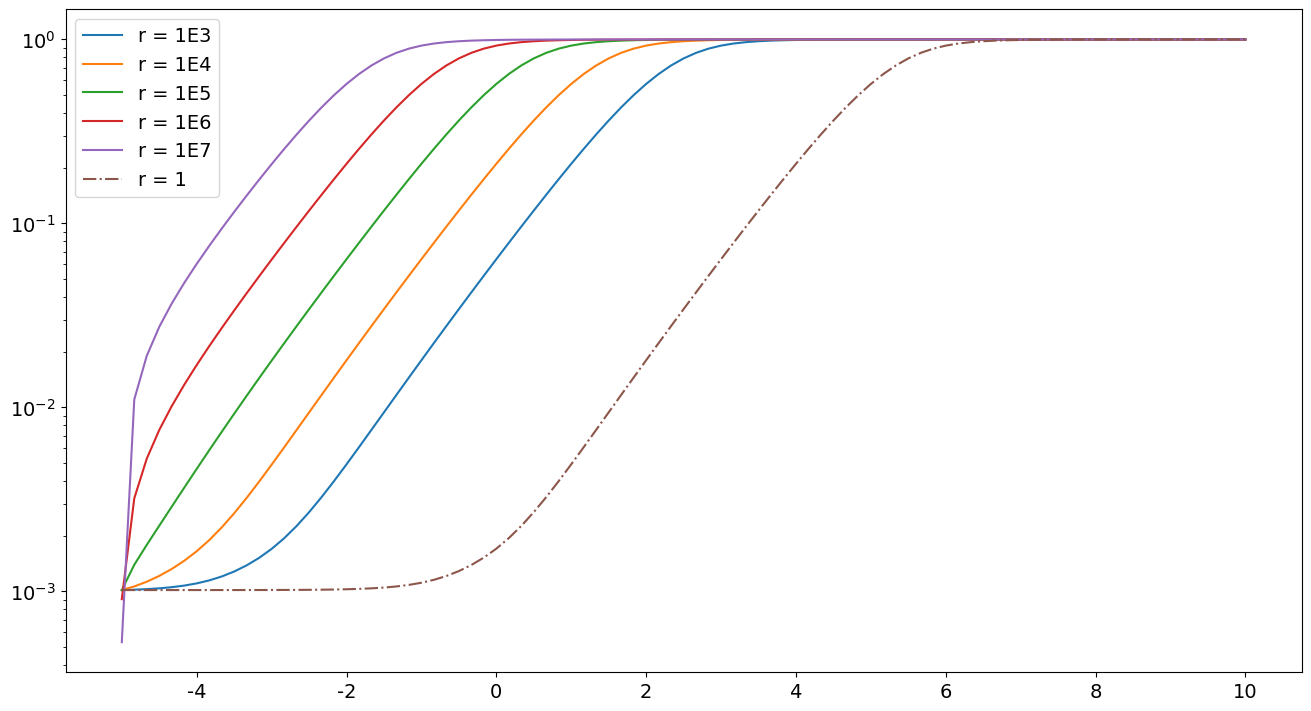

In [31]:
plt.figure(constrained_layout = True, figsize = (13, 7))
plt.semilogy(logtau_mock, S_mockr3, linestyle = "-", label = "r = 1E3")
plt.semilogy(logtau_mock, S_mockr4, linestyle = "-", label = "r = 1E4")
plt.semilogy(logtau_mock, S_mockr5, linestyle = "-", label = "r = 1E5")
plt.semilogy(logtau_mock, S_mockr6, linestyle = "-", label = "r = 1E6")
plt.semilogy(logtau_mock, S_mockr7, linestyle = "-", label = "r = 1E7")
plt.semilogy(logtau_mock, S_mockr1, linestyle = "-.", label = "r = 1")
plt.legend()

In [32]:
from sympy import symbols, Eq, solve

x, y, z = symbols('x, y, z')
eq0 = Eq(x + y + z, 1)
eq1 = Eq(0.88729833*x + 0.5*y + 0.11270167*z, 1/2)
eq2 = Eq(0.88729833**2*x + 0.5**2*y + 0.11270167**2*z, 1/3)
eq3 = Eq(0.88729833**3*x + 0.5**3*y + 0.11270167**3*z, 1/4)
eq4 = Eq(0.88729833**4*x + 0.5**4*y + 0.11270167**4*z, 1/5)
eq5 = Eq(0.88729833**5*x + 0.5**5*y + 0.11270167**5*z, 1/6)

solutions = solve([eq0, eq1, eq2], [x, y, z])
print(f"Symbolic solutions: {solutions}")

Symbolic solutions: {x: 0.277777784405947, y: 0.444444431188107, z: 0.277777784405947}


In [33]:
a, b, c, d = symbols('a, b, c, d')
eq0 = Eq(a + b + c + d, 1)
eq1 = Eq(0.06943184*a + 0.33000948*b + 0.66999052*c + 0.93056816*d, 1/2)
eq2 = Eq(0.06943184**2*a + 0.33000948**2*b + 0.66999052**2*c + 0.93056816**2*d, 1/3)
eq3 = Eq(0.06943184**3*a + 0.33000948**3*b + 0.66999052**3*c + 0.93056816**3*d, 1/4)

solutions = solve([eq0, eq1, eq2, eq3], [a, b, c, d])
print(f"Symbolic solutions: {solutions}")

Symbolic solutions: {a: 0.173927419815906, b: 0.326072580184089, c: 0.326072580184104, d: 0.173927419815900}
